# Predicciones de precios de empresas usando RF

# Importando las librerías necesarias:

In [ ]:
!pip install yfinance;

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

import yfinance as yf
import datetime as dt

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Grupo Aeroportuario del Pacífico

### Obteniendo información:

In [ ]:
def info(token_yf, column, titulo):
    aux = yf.Ticker(token_yf).history(period = 'max')
    data = aux.loc[:, column].interpolate(method = 'linear')
    data = pd.DataFrame(data)

    plt.figure(figsize=(18,9))
    sns.lineplot(data=data)
    plt.title(f'{titulo}', fontsize = 25)
    plt.xlabel('Fecha', fontsize = 15)
    plt.ylabel('Precio de cierre (MXN)', fontsize = 15)

    return data

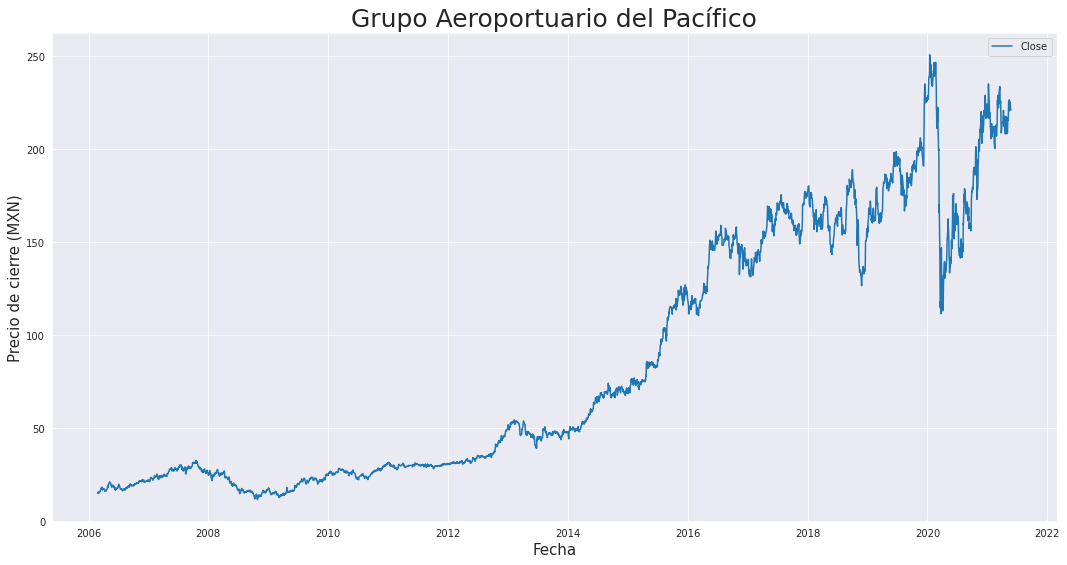

In [ ]:
gap = info('GAPB.MX', 'Close', 'Grupo Aeroportuario del Pacífico')

In [ ]:
gap.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3824 entries, 2006-02-27 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3824 non-null   float64
dtypes: float64(1)
memory usage: 59.8 KB


### Crear predictores:

In [ ]:
def predictores(serie, n_lags, n_diffs):
    data = serie
    for lags in n_lags:
        data[f'Lag {lags}'] = data.iloc[:,0].shift(periods = lags)
    for diffs in n_diffs:
        data[f'Diff {diffs}'] = data.iloc[:,0].diff(periods = diffs)
    data = data.dropna()
    return data

In [ ]:
gap = predictores(gap, [1, 2, 3], [1, 5])

In [ ]:
gap.head()

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2006-03-06  15.401181  15.391301  15.653008  15.391301  0.009880  0.488846
2006-03-07  15.228358  15.401181  15.391301  15.653008 -0.172823  0.399970
2006-03-08  15.257983  15.228358  15.401181  15.391301  0.029625 -0.133318
2006-03-09  15.613508  15.257983  15.228358  15.401181  0.355525 -0.039500
2006-03-10  15.603635  15.613508  15.257983  15.228358 -0.009873  0.212334

### Selección de *train*, *test* y *validation*:

In [ ]:
def train_test_valid(data, train_pct, test_pct, val_pct):
    n = data.shape[0]
    n_train = int(n*train_pct)
    aux = n - n_train
    n_test = int((aux*test_pct)/(test_pct + val_pct))
    n_val = aux - n_test
    return [data.iloc[:n_train, 1:], data.iloc[n_train: (n_train + n_test), 1:],
            data.iloc[(n_train + n_test):, 1:], data.iloc[:n_train, 0],
            data.iloc[n_train: (n_train + n_test), 0],
            data.iloc[(n_train + n_test):, 0]]

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(gap, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1       Lag 2       Lag 3    Diff 1    Diff 5
Date                                                              
2006-03-06   15.391301   15.653008   15.391301  0.009880  0.488846
2006-03-07   15.401181   15.391301   15.653008 -0.172823  0.399970
2006-03-08   15.228358   15.401181   15.391301  0.029625 -0.133318
2006-03-09   15.257983   15.228358   15.401181  0.355525 -0.039500
2006-03-10   15.613508   15.257983   15.228358 -0.009873  0.212334
...                ...         ...         ...       ...       ...
2016-10-20  155.313995  154.834366  152.184464  0.130020  2.836838
2016-10-21  155.444016  155.313995  154.834366  2.438599  5.283585
2016-10-24  157.882614  155.444016  155.313995  0.195099  5.893250
2016-10-25  158.077713  157.882614  155.444016 -4.080582 -0.837234
2016-10-26  153.997131  158.077713  157.882614 -0.235687 -1.552551

[2673 rows x 5 columns]

In [ ]:
X_test

Lag 1       Lag 2       Lag 3    Diff 1    Diff 5
Date                                                              
2016-10-27  153.761444  153.997131  158.077713 -1.300613 -2.983185
2016-10-28  152.460831  153.761444  153.997131 -3.519699 -8.941483
2016-10-31  148.941132  152.460831  153.761444 -0.438965 -9.575546
2016-11-01  148.502167  148.941132  152.460831 -3.243332 -8.738297
2016-11-03  145.258835  148.502167  148.941132 -0.243851 -8.746460
...                ...         ...         ...       ...       ...
2019-11-05  196.410019  197.673584  197.546234  1.116638  0.117554
2019-11-06  197.526657  196.410019  197.673584  1.645554  0.195892
2019-11-07  199.172211  197.526657  196.410019  1.743515  3.369492
2019-11-08  200.915726  199.172211  197.526657 -2.713211  0.528931
2019-11-11  198.202515  200.915726  199.172211  0.342819  2.135315

[764 rows x 5 columns]

In [ ]:
X_val

Lag 1       Lag 2       Lag 3    Diff 1    Diff 5
Date                                                              
2019-11-12  198.545334  198.202515  200.915726  0.842377  1.861053
2019-11-13  199.387711  198.545334  198.202515  0.979507  1.195007
2019-11-14  200.367218  199.387711  198.545334  0.822769  0.274261
2019-11-15  201.189987  200.367218  199.387711  0.010010  2.997482
2019-11-19  201.199997  201.189987  200.367218  4.900009  7.554672
...                ...         ...         ...       ...       ...
2021-05-18  223.759995  226.539993  220.509995  0.830002  1.149994
2021-05-19  224.589996  223.759995  226.539993 -1.119995  2.449997
2021-05-20  223.470001  224.589996  223.759995  1.770004  4.730011
2021-05-21  225.240005  223.470001  224.589996 -4.250000 -5.549988
2021-05-24  220.990005  225.240005  223.470001  0.479996 -2.289993

[382 rows x 5 columns]

In [ ]:
y_train

Date
2006-03-06     15.401181
2006-03-07     15.228358
2006-03-08     15.257983
2006-03-09     15.613508
2006-03-10     15.603635
                 ...    
2016-10-20    155.444016
2016-10-21    157.882614
2016-10-24    158.077713
2016-10-25    153.997131
2016-10-26    153.761444
Name: Close, Length: 2673, dtype: float64

In [ ]:
y_test

Date
2016-10-27    152.460831
2016-10-28    148.941132
2016-10-31    148.502167
2016-11-01    145.258835
2016-11-03    145.014984
                 ...    
2019-11-05    197.526657
2019-11-06    199.172211
2019-11-07    200.915726
2019-11-08    198.202515
2019-11-11    198.545334
Name: Close, Length: 764, dtype: float64

In [ ]:
y_val

Date
2019-11-12    199.387711
2019-11-13    200.367218
2019-11-14    201.189987
2019-11-15    201.199997
2019-11-19    206.100006
                 ...    
2021-05-18    224.589996
2021-05-19    223.470001
2021-05-20    225.240005
2021-05-21    220.990005
2021-05-24    221.470001
Name: Close, Length: 382, dtype: float64

### Aplicación del *Random Forest*:

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

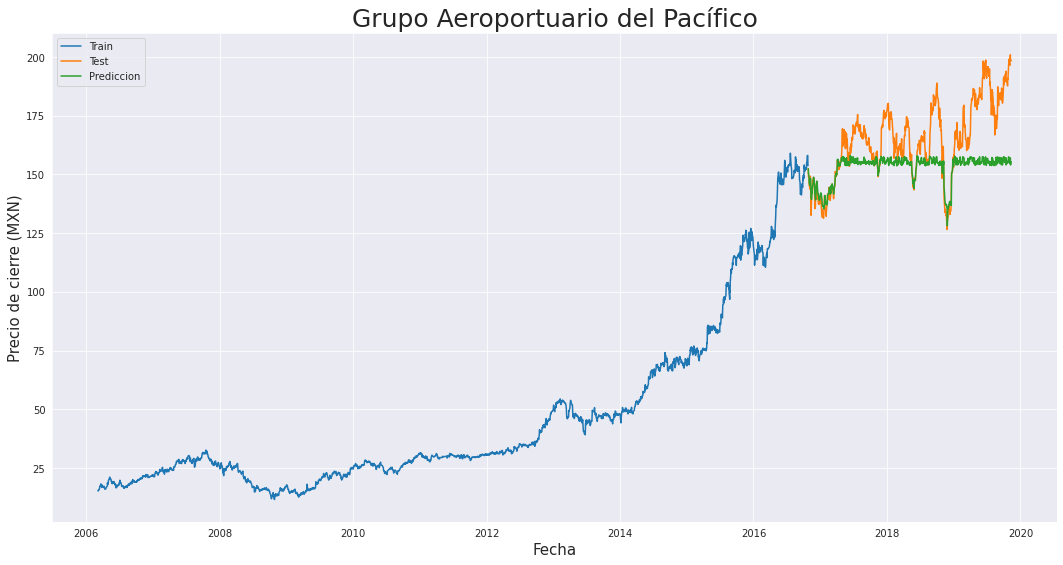

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Grupo Aeroportuario del Pacífico', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

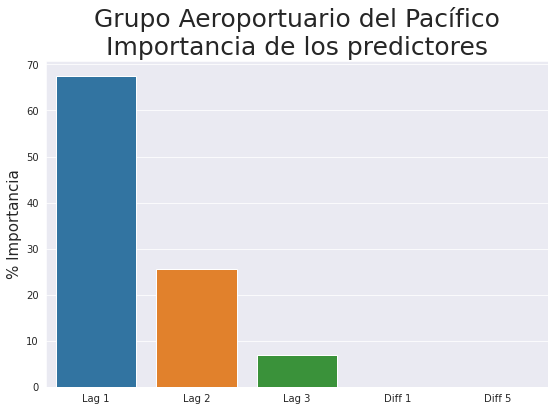

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Grupo Aeroportuario del Pacífico\nImportancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

¿Cómo elegir el número adecuado de ```n_estimators```?
Bueno, veamos cual minimiza la métrica



In [ ]:
def optimizer(X_train, y_train, X_test, y_test, n_estimator, rand):
    mse = []
    for iters in n_estimator:
        mod = RandomForestRegressor(n_estimators = iters, random_state = rand)
        mod.fit(X_train, y_train)
        preds = mod.predict(X_test)
        mse.append(mean_squared_error(y_test, preds))
    
    plt.figure(figsize=(9,6))
    plt.scatter(n_estimator, mse)
    plt.title('Error cuadrático medio', fontsize=25)
    plt.xlabel('Número de estimadores', fontsize = 15)
    plt.ylabel('MSE', fontsize = 15)
    plt.show()

    return f'El número mínimo de estimadores es {n_estimator[mse.index(min(mse))]}'

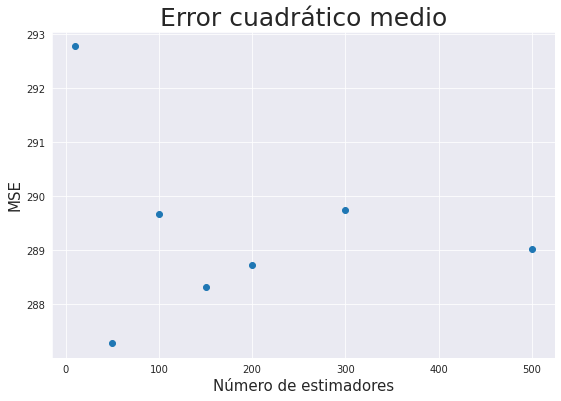

'El número mínimo de estimadores es 50'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

¡50 estimadores y solamente los primeros 3 lags se requieren para hacer un buen modelo!

A partir de esto hagamos un RF con los conjuntos *train* y *test* que tenga 50 estimadores y solo tenga los lags como predictores:

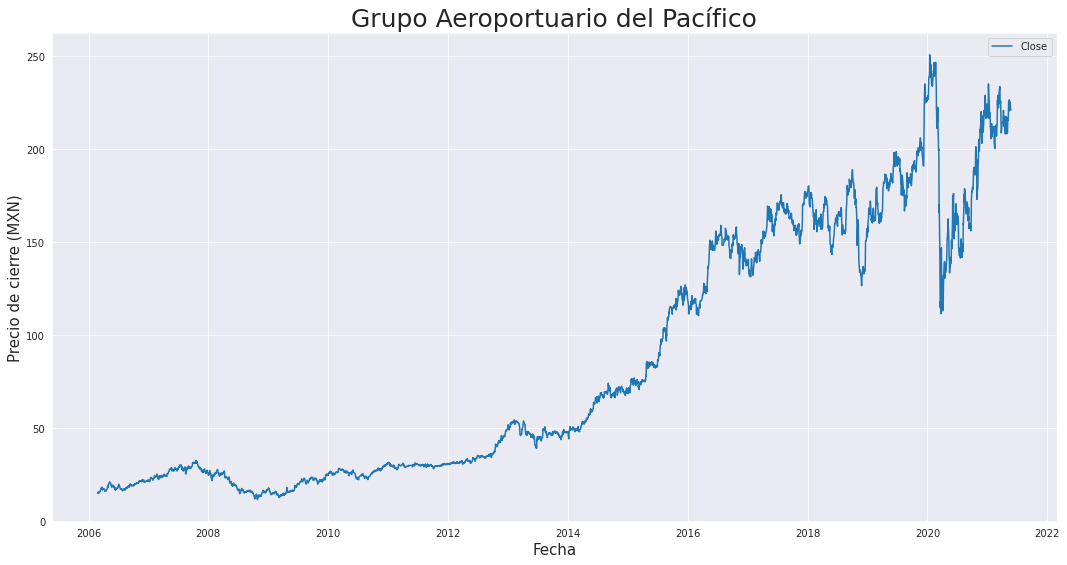

In [ ]:
gap = info('GAPB.MX', 'Close', 'Grupo Aeroportuario del Pacífico')
gap = predictores(gap, [1, 2, 3], [])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(gap, 0.9, 0.1, 0)

In [ ]:
X_train

Lag 1       Lag 2       Lag 3
Date                                          
2006-03-02   15.391301   14.828388   14.912335
2006-03-03   15.653008   15.391301   14.828388
2006-03-06   15.391301   15.653008   15.391301
2006-03-07   15.401181   15.391301   15.653008
2006-03-08   15.228358   15.401181   15.391301
...                ...         ...         ...
2019-11-04  197.673584  197.546234  198.976318
2019-11-05  196.410019  197.673584  197.546234
2019-11-06  197.526657  196.410019  197.673584
2019-11-07  199.172211  197.526657  196.410019
2019-11-08  200.915726  199.172211  197.526657

[3438 rows x 3 columns]

In [ ]:
X_test

Lag 1       Lag 2       Lag 3
Date                                          
2019-11-11  198.202515  200.915726  199.172211
2019-11-12  198.545334  198.202515  200.915726
2019-11-13  199.387711  198.545334  198.202515
2019-11-14  200.367218  199.387711  198.545334
2019-11-15  201.189987  200.367218  199.387711
...                ...         ...         ...
2021-05-18  223.759995  226.539993  220.509995
2021-05-19  224.589996  223.759995  226.539993
2021-05-20  223.470001  224.589996  223.759995
2021-05-21  225.240005  223.470001  224.589996
2021-05-24  220.990005  225.240005  223.470001

[383 rows x 3 columns]

In [ ]:
X_val

Empty DataFrame
Columns: [Lag 1, Lag 2, Lag 3]
Index: []

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 50, random_state = 1)

In [ ]:
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

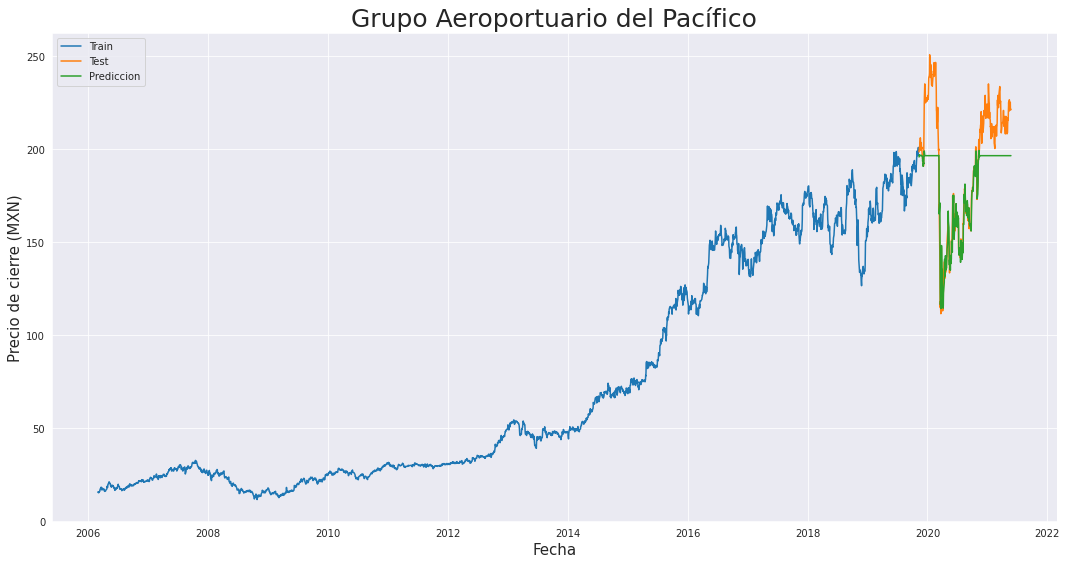

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Grupo Aeroportuario del Pacífico', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

Algo que ocurre en el modelo es que **falla al predecir precios que están por encima del máximo que se usa en train**

Sin embargo es bastante bueno prediciendo precios debajo del máximo

Además de este problema el modelo tiene un problema más, y quizá más importante:
**Para hacer predicciones requerimos información que no se tiene!!!** pues los predictores los hemos calculado a partir de los precios que teniamos.

Ataquemos ambos problemas:
- Para resolver el primer problema basta con incluir el máximo de la serie en el conjunto *train*

- Para hacer predicciones podemos retroalimentar los datos con predicciones (esto quedará más claro cuando hagamos el código)

Vamos por el máximo de la serie:




In [ ]:
gap

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2006-03-02   15.653008   15.391301   14.828388   14.912335
2006-03-03   15.391301   15.653008   15.391301   14.828388
2006-03-06   15.401181   15.391301   15.653008   15.391301
2006-03-07   15.228358   15.401181   15.391301   15.653008
2006-03-08   15.257983   15.228358   15.401181   15.391301
...                ...         ...         ...         ...
2021-05-18  224.589996  223.759995  226.539993  220.509995
2021-05-19  223.470001  224.589996  223.759995  226.539993
2021-05-20  225.240005  223.470001  224.589996  223.759995
2021-05-21  220.990005  225.240005  223.470001  224.589996
2021-05-24  221.470001  220.990005  225.240005  223.470001

[3821 rows x 4 columns]

In [ ]:
gap[gap['Close'] == gap['Close'].max()]

Close       Lag 1       Lag 2       Lag 3
Date                                                  
2020-01-15  250.75  241.029999  239.619995  238.639999

¡El 15 de enero del 2020 se alcanza el máximo!

Por comodidad usemos como conjunto *train* los datos hasta febrero del 2020 y como *test* el resto de los datos:

In [ ]:
train = gap.loc[:'2020-02-01',:]
train

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2006-03-02   15.653008   15.391301   14.828388   14.912335
2006-03-03   15.391301   15.653008   15.391301   14.828388
2006-03-06   15.401181   15.391301   15.653008   15.391301
2006-03-07   15.228358   15.401181   15.391301   15.653008
2006-03-08   15.257983   15.228358   15.401181   15.391301
...                ...         ...         ...         ...
2020-01-27  234.410004  239.679993  240.990005  244.800003
2020-01-28  237.949997  234.410004  239.679993  240.990005
2020-01-29  237.000000  237.949997  234.410004  239.679993
2020-01-30  237.789993  237.000000  237.949997  234.410004
2020-01-31  233.854996  237.789993  237.000000  237.949997

[3494 rows x 4 columns]

In [ ]:
test = gap.loc['2020-02-01':,:]
test

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2020-02-04  238.964996  233.854996  237.789993  237.000000
2020-02-05  240.220001  238.964996  233.854996  237.789993
2020-02-06  240.020004  240.220001  238.964996  233.854996
2020-02-07  242.000000  240.020004  240.220001  238.964996
2020-02-10  239.110001  242.000000  240.020004  240.220001
...                ...         ...         ...         ...
2021-05-18  224.589996  223.759995  226.539993  220.509995
2021-05-19  223.470001  224.589996  223.759995  226.539993
2021-05-20  225.240005  223.470001  224.589996  223.759995
2021-05-21  220.990005  225.240005  223.470001  224.589996
2021-05-24  221.470001  220.990005  225.240005  223.470001

[327 rows x 4 columns]

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

In [ ]:
rf_prob1 = RandomForestRegressor(n_estimators=50, random_state=1)
rf_prob1.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_prob1.predict(X_test)

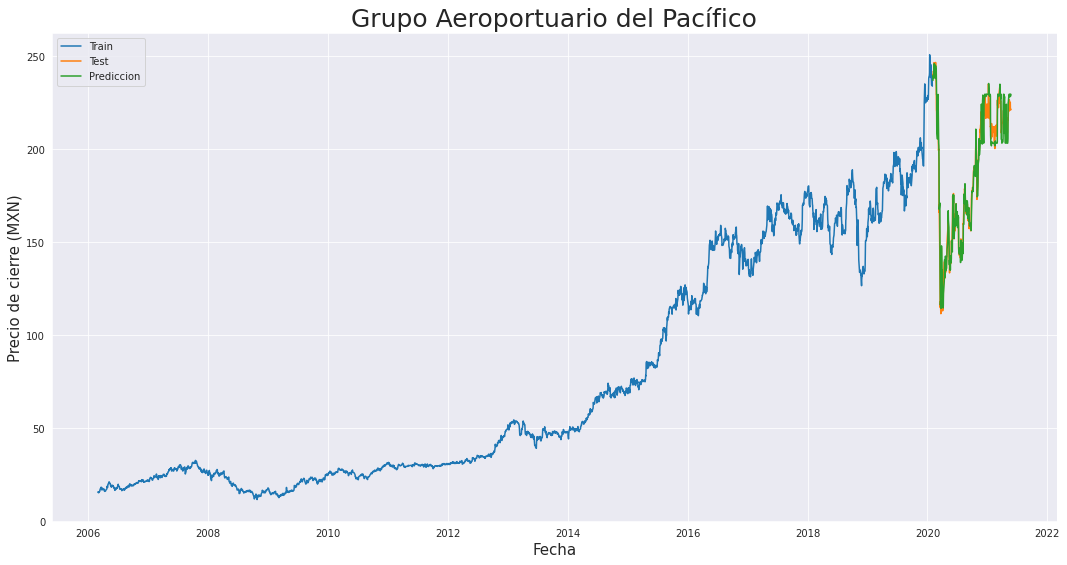

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Grupo Aeroportuario del Pacífico', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

55.14620142409568

In [ ]:
rf_prob1.score(X_test, y_test)

0.9518934598077059

Muchisimo mejor!!!

Ahora, para atacar el segundo problema basta hacer la siguiente observación: **para hacer una predicción requerimos los tres días anteriores al precio que se intenta predecir**

Con esto en mente podemos hacer una predicción del precio de mañana $y_{t+1}$ pues tenemos los precios de hoy $y_t$, ayer $y_{t-1}$ y antier $y_{t-2}$.

Para predecir los precios de pasado mañana requeriremos los precios de mañana, hoy y ayer, sin embargo el precio de mañana es una predicción.

Con esto en mente **sí podemos hacer predicciones de precios futuros** solamente que para el cuarto día usaremos predictores que hemos predicho.

Hagamos una función que nos prediga pues los precios del futuro:

In [ ]:
def futuro(data, n_estimator, rand, dias = 1):
    RF = RandomForestRegressor(n_estimators=n_estimator, random_state=rand)
    RF.fit(data.iloc[:, 1:], data.iloc[:,0])

    fut = pd.DataFrame(index=np.arange(dias), columns=data.columns)
    n = len(data.columns)
    
    for i in range(dias):
        if i == 0:
            fut.iloc[0, 1:] = data.iloc[-1, :(n-1)].values
            fut.iloc[0, 0] = RF.predict(fut.iloc[0, 1:].values.reshape(1,-1))[0]
        else:
            fut.iloc[i, 1:] = fut.iloc[(i-1), :(n-1)].values
            fut.iloc[i, 0] = RF.predict(fut.iloc[i, 1:].values.reshape(1,-1))[0]
    
    return fut.astype('float')

In [ ]:
gap.tail()

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-05-18  224.589996  223.759995  226.539993  220.509995
2021-05-19  223.470001  224.589996  223.759995  226.539993
2021-05-20  225.240005  223.470001  224.589996  223.759995
2021-05-21  220.990005  225.240005  223.470001  224.589996
2021-05-24  221.470001  220.990005  225.240005  223.470001

In [ ]:
futuro(gap, 50, 1, 10)

Close       Lag 1       Lag 2       Lag 3
0  219.532397  221.470001  220.990005  225.240005
1  220.725397  219.532397  221.470001  220.990005
2  221.752998  220.725397  219.532397  221.470001
3  222.077198  221.752998  220.725397  219.532397
4  221.579797  222.077198  221.752998  220.725397
5  222.162597  221.579797  222.077198  221.752998
6  221.557797  222.162597  221.579797  222.077198
7  222.183997  221.557797  222.162597  221.579797
8  221.558196  222.183997  221.557797  222.162597
9  222.183997  221.558196  222.183997  221.557797

Resueltos ambos problemas veamos como se comporta el modelo sin datos para predecir. Vamos a predecir todo el mes de mayo de 2021:

In [ ]:
train = gap.loc[:'2020-02-01', :]
test = gap.loc['2020-02-01':'2021-05-01', :]
val = gap.loc['2021-05-01':, :]

In [ ]:
train

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2006-03-02   15.653008   15.391301   14.828388   14.912335
2006-03-03   15.391301   15.653008   15.391301   14.828388
2006-03-06   15.401181   15.391301   15.653008   15.391301
2006-03-07   15.228358   15.401181   15.391301   15.653008
2006-03-08   15.257983   15.228358   15.401181   15.391301
...                ...         ...         ...         ...
2020-01-27  234.410004  239.679993  240.990005  244.800003
2020-01-28  237.949997  234.410004  239.679993  240.990005
2020-01-29  237.000000  237.949997  234.410004  239.679993
2020-01-30  237.789993  237.000000  237.949997  234.410004
2020-01-31  233.854996  237.789993  237.000000  237.949997

[3494 rows x 4 columns]

In [ ]:
test

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2020-02-04  238.964996  233.854996  237.789993  237.000000
2020-02-05  240.220001  238.964996  233.854996  237.789993
2020-02-06  240.020004  240.220001  238.964996  233.854996
2020-02-07  242.000000  240.020004  240.220001  238.964996
2020-02-10  239.110001  242.000000  240.020004  240.220001
...                ...         ...         ...         ...
2021-04-26  212.539993  217.660004  214.490005  214.279999
2021-04-27  212.089996  212.539993  217.660004  214.490005
2021-04-28  210.690002  212.089996  212.539993  217.660004
2021-04-29  211.419998  210.690002  212.089996  212.539993
2021-04-30  208.240005  211.419998  210.690002  212.089996

[311 rows x 4 columns]

In [ ]:
val

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-05-03  208.979996  208.240005  211.419998  210.690002
2021-05-04  213.699997  208.979996  208.240005  211.419998
2021-05-05  214.880005  213.699997  208.979996  208.240005
2021-05-06  216.800003  214.880005  213.699997  208.979996
2021-05-07  215.580002  216.800003  214.880005  213.699997
2021-05-10  225.199997  215.580002  216.800003  214.880005
2021-05-11  223.440002  225.199997  215.580002  216.800003
2021-05-12  221.020004  223.440002  225.199997  215.580002
2021-05-13  220.509995  221.020004  223.440002  225.199997
2021-05-14  226.539993  220.509995  221.020004  223.440002
2021-05-17  223.759995  226.539993  220.509995  221.020004
2021-05-18  224.589996  223.759995  226.539993  220.509995
2021-05-19  223.470001  224.589996  223.759995  226.539993
2021-05-20  225.240005  223.470001  224.589996  223.759995
2021-05-21  220.990005  225.240005  223.470001  224.589996
2021-05-24  221.470001  220.990005  225.240005  223.470001

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

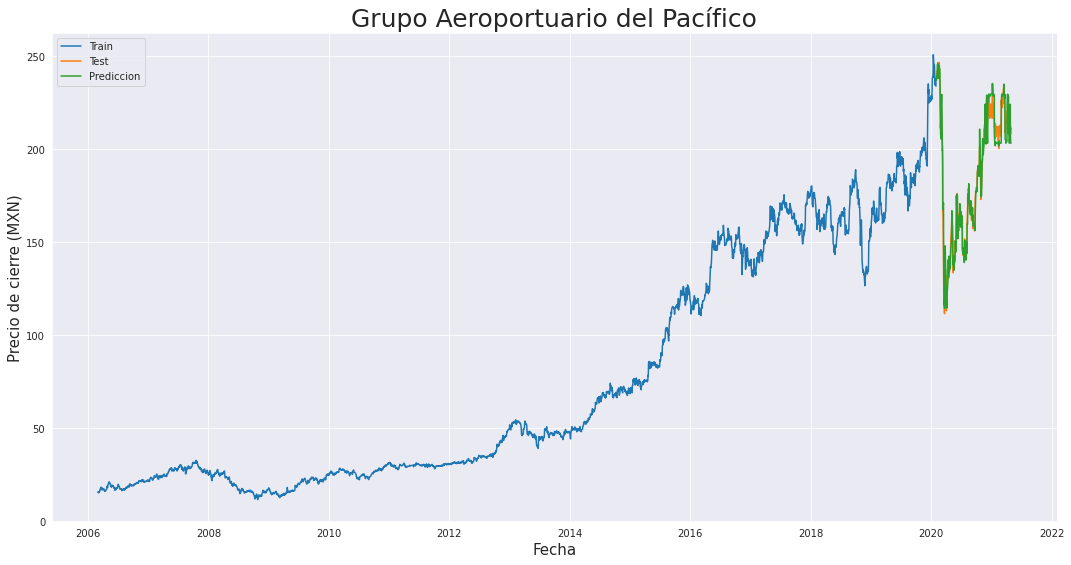

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Grupo Aeroportuario del Pacífico', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

55.22476924586453

In [ ]:
RF.score(X_test, y_test)

0.9517886358838195

In [ ]:
test.tail()

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-04-26  212.539993  217.660004  214.490005  214.279999
2021-04-27  212.089996  212.539993  217.660004  214.490005
2021-04-28  210.690002  212.089996  212.539993  217.660004
2021-04-29  211.419998  210.690002  212.089996  212.539993
2021-04-30  208.240005  211.419998  210.690002  212.089996

In [ ]:
aux = gap.loc[:'2021-05-01', :]
fin = futuro(aux, 50, 1, len(y_val))
fin

Close       Lag 1       Lag 2       Lag 3
0   209.293999  208.240005  211.419998  210.690002
1   210.791001  209.293999  208.240005  211.419998
2   211.547201  210.791001  209.293999  208.240005
3   211.489802  211.547201  210.791001  209.293999
4   210.959200  211.489802  211.547201  210.791001
5   209.801800  210.959200  211.489802  211.547201
6   209.184198  209.801800  210.959200  211.489802
7   207.422598  209.184198  209.801800  210.959200
8   210.774401  207.422598  209.184198  209.801800
9   212.026002  210.774401  207.422598  209.184198
10  211.700400  212.026002  210.774401  207.422598
11  210.488799  211.700400  212.026002  210.774401
12  207.908599  210.488799  211.700400  212.026002
13  207.856800  207.908599  210.488799  211.700400
14  210.715001  207.856800  207.908599  210.488799
15  211.899800  210.715001  207.856800  207.908599

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-05-03  209.293999  208.240005  211.419998  210.690002
2021-05-04  210.791001  209.293999  208.240005  211.419998
2021-05-05  211.547201  210.791001  209.293999  208.240005
2021-05-06  211.489802  211.547201  210.791001  209.293999
2021-05-07  210.959200  211.489802  211.547201  210.791001
2021-05-10  209.801800  210.959200  211.489802  211.547201
2021-05-11  209.184198  209.801800  210.959200  211.489802
2021-05-12  207.422598  209.184198  209.801800  210.959200
2021-05-13  210.774401  207.422598  209.184198  209.801800
2021-05-14  212.026002  210.774401  207.422598  209.184198
2021-05-17  211.700400  212.026002  210.774401  207.422598
2021-05-18  210.488799  211.700400  212.026002  210.774401
2021-05-19  207.908599  210.488799  211.700400  212.026002
2021-05-20  207.856800  207.908599  210.488799  211.700400
2021-05-21  210.715001  207.856800  207.908599  210.488799
2021-05-24  211.899800  210.715001  207.856800  207.908599

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close        Pred
Date                              
2021-05-03  208.979996  209.293999
2021-05-04  213.699997  210.791001
2021-05-05  214.880005  211.547201
2021-05-06  216.800003  211.489802
2021-05-07  215.580002  210.959200
2021-05-10  225.199997  209.801800
2021-05-11  223.440002  209.184198
2021-05-12  221.020004  207.422598
2021-05-13  220.509995  210.774401
2021-05-14  226.539993  212.026002
2021-05-17  223.759995  211.700400
2021-05-18  224.589996  210.488799
2021-05-19  223.470001  207.908599
2021-05-20  225.240005  207.856800
2021-05-21  220.990005  210.715001
2021-05-24  221.470001  211.899800

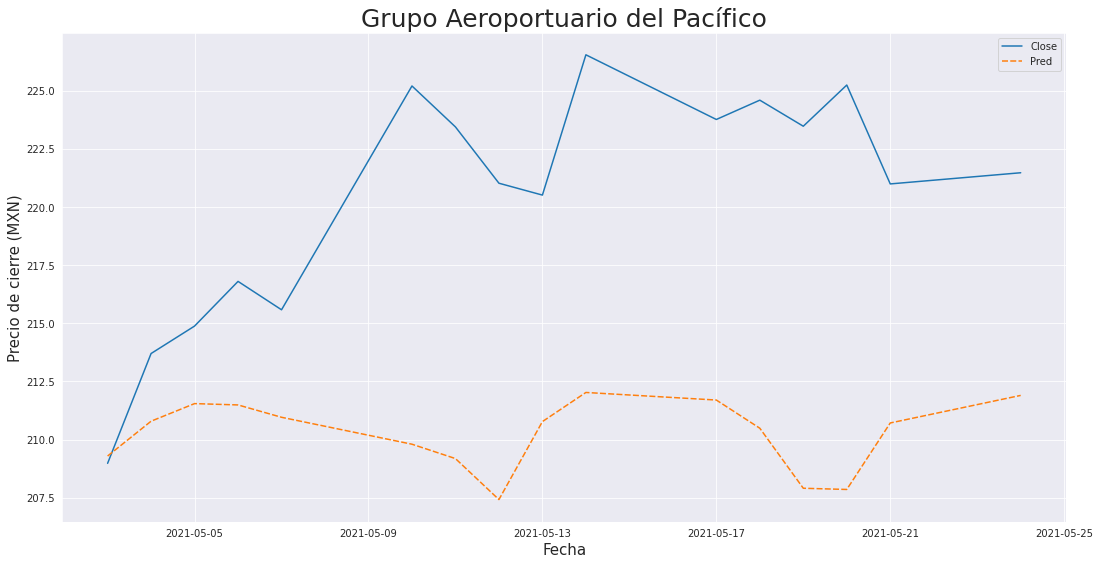

In [ ]:
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('Grupo Aeroportuario del Pacífico', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

130.35333106576175

##Cemex

###Obteniendo informacion:

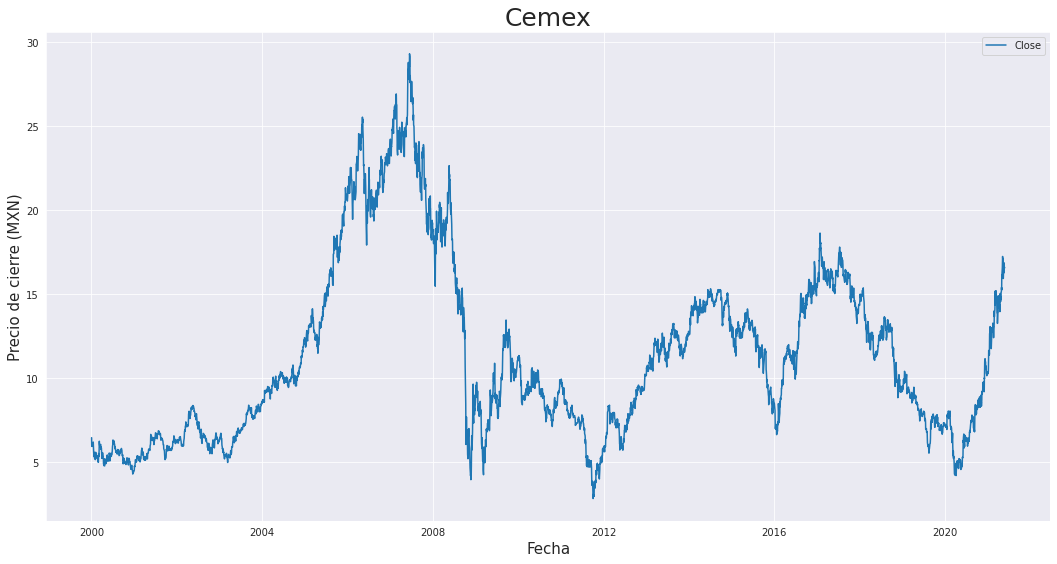

In [ ]:
cmx = info('CEMEXCPO.MX', 'Close', 'Cemex')

In [ ]:
cmx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5394 entries, 2000-01-03 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5394 non-null   float64
dtypes: float64(1)
memory usage: 84.3 KB


###Crear predictores:

In [ ]:
cmx = predictores(cmx, [1, 2, 3], [1, 5])
cmx.head()

Close     Lag 1     Lag 2     Lag 3    Diff 1    Diff 5
Date                                                                  
2000-01-10  6.127980  6.003679  5.941530  6.040969  0.124300 -0.335611
2000-01-11  5.985035  6.127980  6.003679  5.941530 -0.142944 -0.031074
2000-01-12  5.972605  5.985035  6.127980  6.003679 -0.012431 -0.068364
2000-01-13  6.016109  5.972605  5.985035  6.127980  0.043505  0.074580
2000-01-14  6.115549  6.016109  5.972605  5.985035  0.099440  0.111870

###Seleccion de train, test y validation

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(cmx, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2000-01-10   6.003679   5.941530   6.040969  0.124300 -0.335611
2000-01-11   6.127980   6.003679   5.941530 -0.142944 -0.031074
2000-01-12   5.985035   6.127980   6.003679 -0.012431 -0.068364
2000-01-13   5.972605   5.985035   6.127980  0.043505  0.074580
2000-01-14   6.016109   5.972605   5.985035  0.099440  0.111870
...               ...        ...        ...       ...       ...
2014-12-05  14.237423  14.298080  14.358739  0.077989 -0.649914
2014-12-08  14.315412  14.237423  14.298080 -0.225303 -0.563258
2014-12-09  14.090109  14.315412  14.237423 -0.285963 -0.554593
2014-12-10  13.804146  14.090109  14.315412 -0.363950 -0.857884
2014-12-11  13.440196  13.804146  14.090109  0.138647 -0.658580

[3772 rows x 5 columns]

In [ ]:
X_test

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2014-12-15  13.578843  13.440196  13.804146 -0.788560 -1.525128
2014-12-16  12.790283  13.578843  13.440196  0.017331 -1.282495
2014-12-17  12.807614  12.790283  13.578843  0.268631 -0.727901
2014-12-18  13.076245  12.807614  12.790283  0.597919  0.233969
2014-12-19  13.674165  13.076245  12.807614 -0.086656  0.008666
...               ...        ...        ...       ...       ...
2019-03-25   8.529074   9.084682   9.152915  0.370406 -0.029242
2019-03-26   8.899480   8.529074   9.084682 -0.126719 -0.282679
2019-03-27   8.772761   8.899480   8.529074  0.194951 -0.185203
2019-03-28   8.967712   8.772761   8.899480 -0.311921 -0.428890
2019-03-29   8.655791   8.967712   8.772761  0.185203  0.311920

[1078 rows x 5 columns]

In [ ]:
X_val

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2019-04-01   8.840994   8.655791   8.967712  0.116970  0.058484
2019-04-02   8.957964   8.840994   8.655791 -0.038989  0.146214
2019-04-03   8.918975   8.957964   8.840994  0.107223  0.058485
2019-04-04   9.026197   8.918975   8.957964  0.097475  0.467881
2019-04-05   9.123672   9.026197   8.918975  0.136465  0.419144
...               ...        ...        ...       ...       ...
2021-05-18  16.870001  16.620001  16.139999 -0.260000 -0.490000
2021-05-19  16.610001  16.870001  16.620001 -0.340000  0.340000
2021-05-20  16.270000  16.610001  16.870001  0.359999  0.490000
2021-05-21  16.629999  16.270000  16.610001 -0.089998 -0.080000
2021-05-24  16.540001  16.629999  16.270000  0.049999 -0.280001

[539 rows x 5 columns]

In [ ]:
y_train

Date
2000-01-10     6.127980
2000-01-11     5.985035
2000-01-12     5.972605
2000-01-13     6.016109
2000-01-14     6.115549
                ...    
2014-12-05    14.315412
2014-12-08    14.090109
2014-12-09    13.804146
2014-12-10    13.440196
2014-12-11    13.578843
Name: Close, Length: 3772, dtype: float64

In [ ]:
y_test

Date
2014-12-15    12.790283
2014-12-16    12.807614
2014-12-17    13.076245
2014-12-18    13.674165
2014-12-19    13.587509
                ...    
2019-03-25     8.899480
2019-03-26     8.772761
2019-03-27     8.967712
2019-03-28     8.655791
2019-03-29     8.840994
Name: Close, Length: 1078, dtype: float64

In [ ]:
y_val

Date
2019-04-01     8.957964
2019-04-02     8.918975
2019-04-03     9.026197
2019-04-04     9.123672
2019-04-05     9.260138
                ...    
2021-05-18    16.610001
2021-05-19    16.270000
2021-05-20    16.629999
2021-05-21    16.540001
2021-05-24    16.590000
Name: Close, Length: 539, dtype: float64

### Aplicacion del random forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

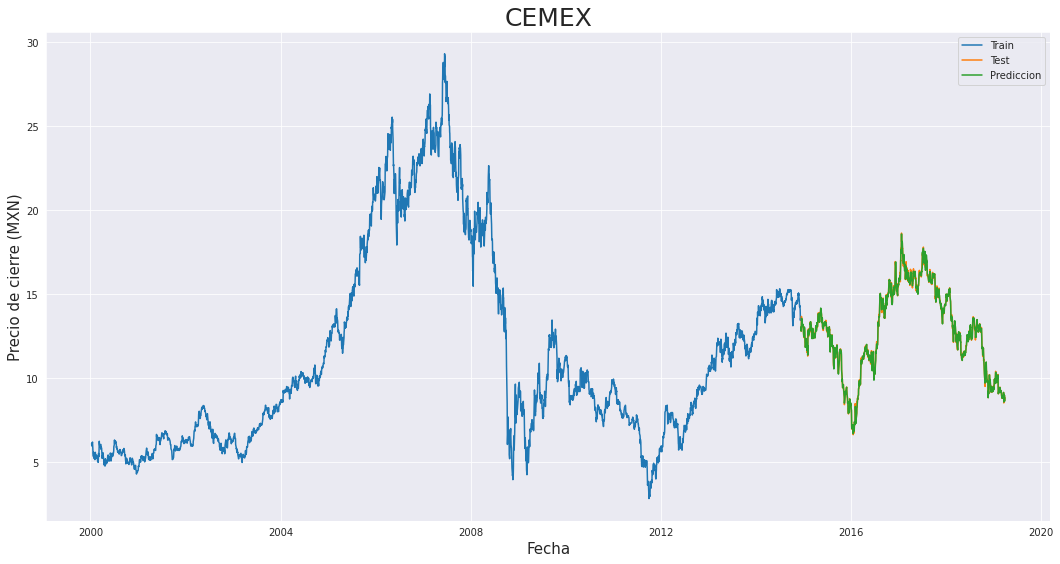

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('CEMEX', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

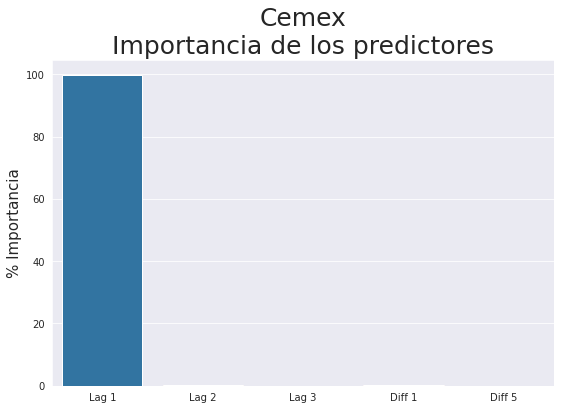

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Cemex\nImportancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

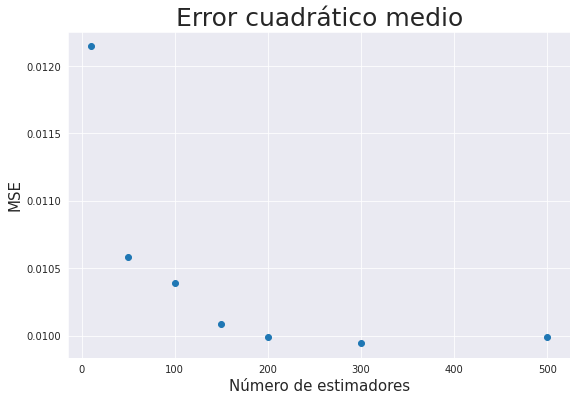

'El número mínimo de estimadores es 300'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

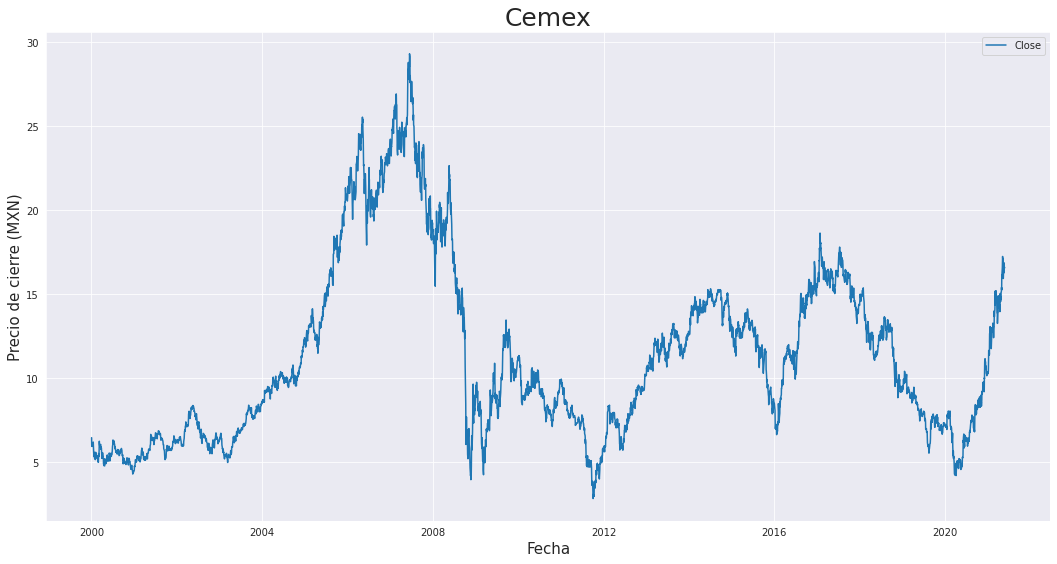

In [ ]:
cmx = info('CEMEXCPO.MX', 'Close', 'Cemex')
cmx = predictores(cmx, [1], [])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(cmx, 0.9, 0.1, 0)

In [ ]:
X_train

Lag 1
Date                
2000-01-04  6.463591
2000-01-05  6.016109
2000-01-06  6.040969
2000-01-07  5.941530
2000-01-10  6.003679
...              ...
2019-03-22  9.084682
2019-03-25  8.529074
2019-03-26  8.899480
2019-03-27  8.772761
2019-03-28  8.967712

[4853 rows x 1 columns]

In [ ]:
X_test

Lag 1
Date                 
2019-03-29   8.655791
2019-04-01   8.840994
2019-04-02   8.957964
2019-04-03   8.918975
2019-04-04   9.026197
...               ...
2021-05-18  16.870001
2021-05-19  16.610001
2021-05-20  16.270000
2021-05-21  16.629999
2021-05-24  16.540001

[540 rows x 1 columns]

In [ ]:
X_val

Empty DataFrame
Columns: [Lag 1]
Index: []

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 300, random_state = 1)
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

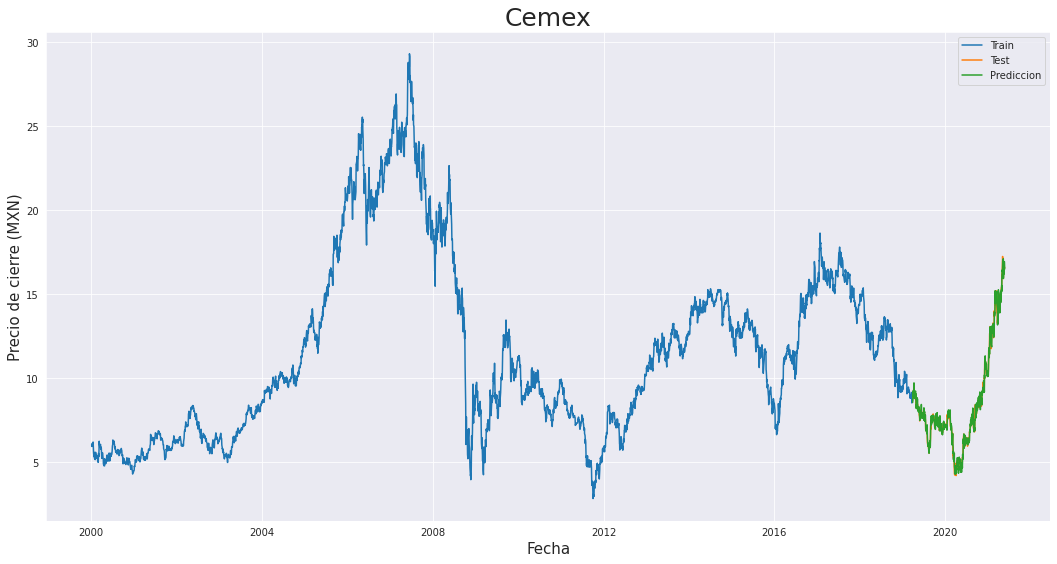

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Cemex', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.07964138784030395

In [ ]:
rf_final.score(X_test, y_test)

0.991034888392611

In [ ]:
cmx.tail( )

Close      Lag 1
Date                            
2021-05-18  16.610001  16.870001
2021-05-19  16.270000  16.610001
2021-05-20  16.629999  16.270000
2021-05-21  16.540001  16.629999
2021-05-24  16.590000  16.540001

In [ ]:
futuro(cmx, 50, 1, 10)

Close      Lag 1
0  16.714977  16.590000
1  16.690341  16.714977
2  17.027565  16.690341
3  17.565720  17.027565
4  17.546101  17.565720
5  17.243189  17.546101
6  17.181500  17.243189
7  16.788280  17.181500
8  16.734137  16.788280
9  16.535072  16.734137

In [ ]:
train = cmx.loc[:'2020-02-01', :]
test = cmx.loc['2020-02-01':'2021-05-01', :]
val = cmx.loc['2021-05-01':, :]

In [ ]:
train

Close     Lag 1
Date                          
2000-01-04  6.016109  6.463591
2000-01-05  6.040969  6.016109
2000-01-06  5.941530  6.040969
2000-01-07  6.003679  5.941530
2000-01-10  6.127980  6.003679
...              ...       ...
2020-01-27  7.785000  7.870000
2020-01-28  8.050000  7.785000
2020-01-29  7.950000  8.050000
2020-01-30  7.850000  7.950000
2020-01-31  7.595000  7.850000

[5066 rows x 2 columns]

In [ ]:
test

Close      Lag 1
Date                            
2020-02-04   7.945000   7.595000
2020-02-05   7.750000   7.945000
2020-02-06   7.750000   7.750000
2020-02-07   7.790000   7.750000
2020-02-10   7.735000   7.790000
...               ...        ...
2021-04-26  15.200000  15.070000
2021-04-27  15.400000  15.200000
2021-04-28  15.250000  15.400000
2021-04-29  16.139999  15.250000
2021-04-30  16.090000  16.139999

[311 rows x 2 columns]

In [ ]:
val

Close      Lag 1
Date                            
2021-05-03  16.420000  16.090000
2021-05-04  16.600000  16.420000
2021-05-05  16.860001  16.600000
2021-05-06  17.240000  16.860001
2021-05-07  17.129999  17.240000
2021-05-10  16.879999  17.129999
2021-05-11  17.100000  16.879999
2021-05-12  15.930000  17.100000
2021-05-13  16.139999  15.930000
2021-05-14  16.620001  16.139999
2021-05-17  16.870001  16.620001
2021-05-18  16.610001  16.870001
2021-05-19  16.270000  16.610001
2021-05-20  16.629999  16.270000
2021-05-21  16.540001  16.629999
2021-05-24  16.590000  16.540001

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

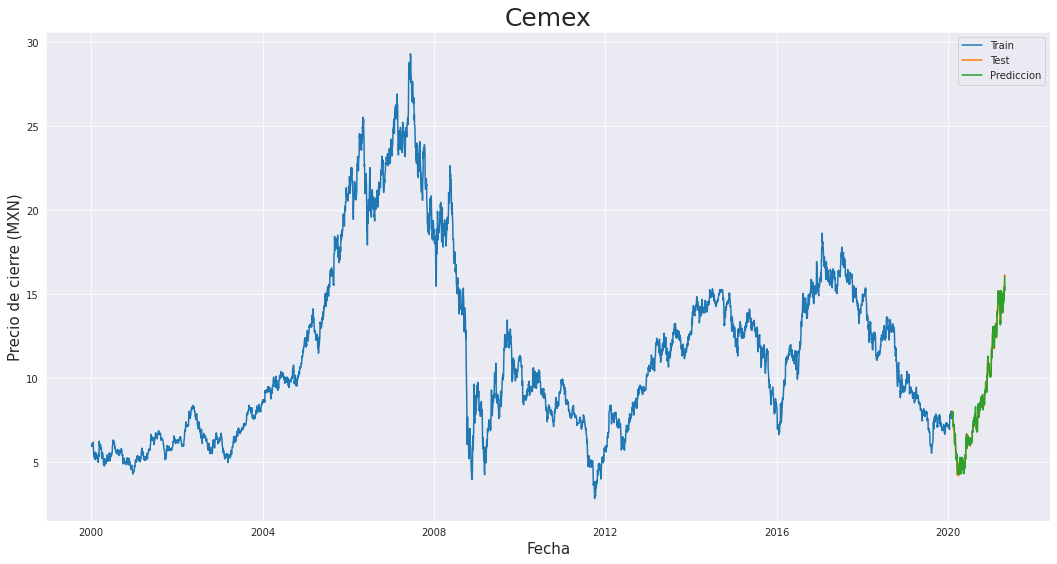

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Cemex', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.09815871393793398

In [ ]:
RF.score(X_test, y_test)

0.9909427502849089

In [ ]:
test.tail()

Close      Lag 1
Date                            
2021-04-26  15.200000  15.070000
2021-04-27  15.400000  15.200000
2021-04-28  15.250000  15.400000
2021-04-29  16.139999  15.250000
2021-04-30  16.090000  16.139999

In [ ]:
aux = cmx.loc[:'2021-05-01', :]
fin = futuro(aux, 50, 1, len(y_val))
fin

Close      Lag 1
0   16.461841  16.090000
1   16.283793  16.461841
2   16.218325  16.283793
3   16.308578  16.218325
4   16.173105  16.308578
5   16.393436  16.173105
6   16.261299  16.393436
7   16.397818  16.261299
8   16.150695  16.397818
9   16.171551  16.150695
10  16.393436  16.171551
11  16.261299  16.393436
12  16.397818  16.261299
13  16.150695  16.397818
14  16.171551  16.150695
15  16.393436  16.171551

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close      Lag 1
Date                            
2021-05-03  16.461841  16.090000
2021-05-04  16.283793  16.461841
2021-05-05  16.218325  16.283793
2021-05-06  16.308578  16.218325
2021-05-07  16.173105  16.308578
2021-05-10  16.393436  16.173105
2021-05-11  16.261299  16.393436
2021-05-12  16.397818  16.261299
2021-05-13  16.150695  16.397818
2021-05-14  16.171551  16.150695
2021-05-17  16.393436  16.171551
2021-05-18  16.261299  16.393436
2021-05-19  16.397818  16.261299
2021-05-20  16.150695  16.397818
2021-05-21  16.171551  16.150695
2021-05-24  16.393436  16.171551

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close       Pred
Date                            
2021-05-03  16.420000  16.461841
2021-05-04  16.600000  16.283793
2021-05-05  16.860001  16.218325
2021-05-06  17.240000  16.308578
2021-05-07  17.129999  16.173105
2021-05-10  16.879999  16.393436
2021-05-11  17.100000  16.261299
2021-05-12  15.930000  16.397818
2021-05-13  16.139999  16.150695
2021-05-14  16.620001  16.171551
2021-05-17  16.870001  16.393436
2021-05-18  16.610001  16.261299
2021-05-19  16.270000  16.397818
2021-05-20  16.629999  16.150695
2021-05-21  16.540001  16.171551
2021-05-24  16.590000  16.393436

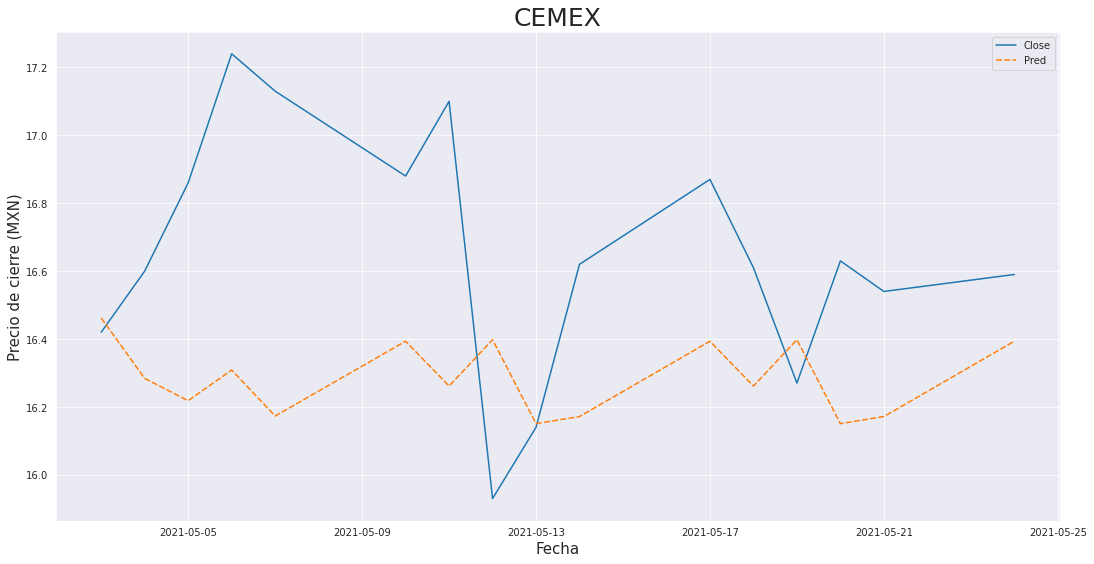

In [ ]:
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('CEMEX', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

0.276630429308571

## Walmart

### Obteninedo informacion

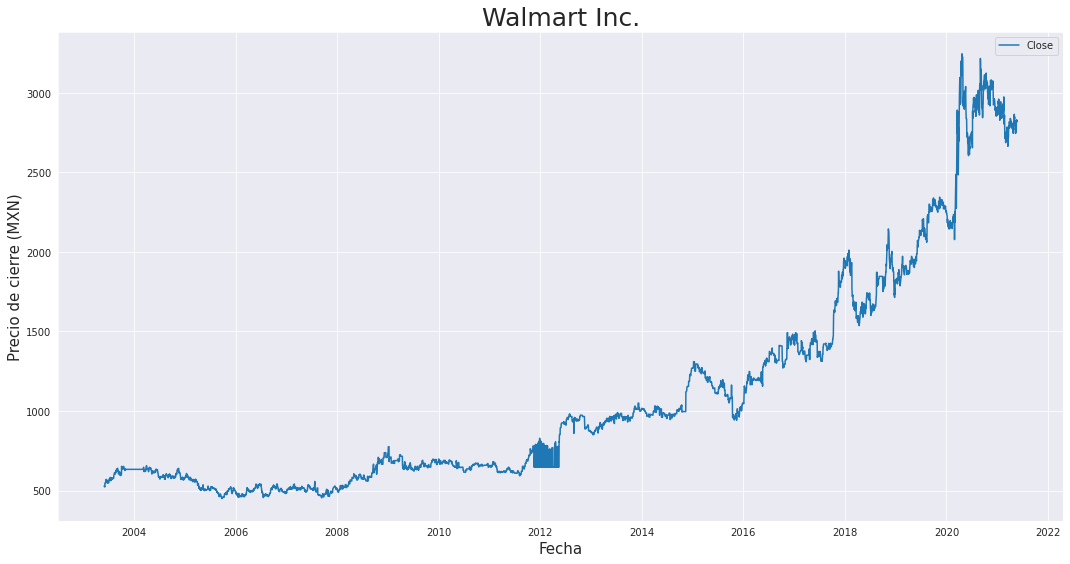

In [ ]:
walmart = info('WMT.MX', 'Close', 'Walmart Inc.')

In [ ]:
walmart = walmart.loc['2012-06-01' :]

In [ ]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2249 entries, 2012-06-01 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2249 non-null   float64
dtypes: float64(1)
memory usage: 35.1 KB


###Crear predictores


In [ ]:
walmart = predictores(walmart, [1, 2, 3], [1, 5])

In [ ]:
walmart.head()

Close       Lag 1       Lag 2       Lag 3  Diff 1    Diff 5
Date                                                                        
2012-06-08  925.735535  925.735535  925.735535  925.735535     0.0  2.261353
2012-06-11  925.735535  925.735535  925.735535  925.735535     0.0 -0.009949
2012-06-12  925.735535  925.735535  925.735535  925.735535     0.0  0.000000
2012-06-13  925.735535  925.735535  925.735535  925.735535     0.0  0.000000
2012-06-14  925.735535  925.735535  925.735535  925.735535     0.0  0.000000

###Seleccion de train, test y validation:

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(walmart, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1        Lag 2        Lag 3  Diff 1     Diff 5
Date                                                                
2012-06-08   925.735535   925.735535   925.735535     0.0   2.261353
2012-06-11   925.735535   925.735535   925.735535     0.0  -0.009949
2012-06-12   925.735535   925.735535   925.735535     0.0   0.000000
2012-06-13   925.735535   925.735535   925.735535     0.0   0.000000
2012-06-14   925.735535   925.735535   925.735535     0.0   0.000000
...                 ...          ...          ...     ...        ...
2018-09-06  1846.520996  1846.520996  1831.557129     0.0  14.963867
2018-09-07  1846.520996  1846.520996  1846.520996     0.0  14.963867
2018-09-10  1846.520996  1846.520996  1846.520996     0.0  14.963867
2018-09-11  1846.520996  1846.520996  1846.520996     0.0   0.000000
2018-09-12  1846.520996  1846.520996  1846.520996     0.0   0.000000

[1570 rows x 5 columns]

In [ ]:
X_test

Lag 1        Lag 2        Lag 3     Diff 1     Diff 5
Date                                                                   
2018-09-13  1846.520996  1846.520996  1846.520996   0.000000   0.000000
2018-09-14  1846.520996  1846.520996  1846.520996   0.000000   0.000000
2018-09-17  1846.520996  1846.520996  1846.520996   0.000000   0.000000
2018-09-18  1846.520996  1846.520996  1846.520996   0.000000   0.000000
2018-09-19  1846.520996  1846.520996  1846.520996   0.000000   0.000000
...                 ...          ...          ...        ...        ...
2020-06-24  2718.095703  2732.824463  2694.423828  18.815674  88.432129
2020-06-25  2736.911377  2718.095703  2732.824463 -24.480957  25.480469
2020-06-26  2712.430420  2736.911377  2718.095703  15.997803  34.004395
2020-06-29  2728.428223  2712.430420  2736.911377  22.222900  17.826660
2020-06-30  2750.651123  2728.428223  2712.430420 -28.728271   3.827148

[449 rows x 5 columns]

In [ ]:
X_val

Lag 1        Lag 2        Lag 3      Diff 1      Diff 5
Date                                                                     
2020-07-01  2721.922852  2750.651123  2728.428223   34.973389   19.984863
2020-07-02  2756.896240  2721.922852  2750.651123  -69.936279  -25.470459
2020-07-03  2686.959961  2756.896240  2721.922852    0.000000  -41.468262
2020-07-06  2686.959961  2686.959961  2756.896240  -31.546387  -95.237549
2020-07-07  2655.413574  2686.959961  2686.959961  229.744873  163.235596
...                 ...          ...          ...         ...         ...
2021-05-18  2755.000000  2775.649902  2770.000000   71.610107   44.750000
2021-05-19  2826.610107  2755.000000  2775.649902   -6.610107   75.000000
2021-05-20  2820.000000  2826.610107  2755.000000   11.000000   61.000000
2021-05-21  2831.000000  2820.000000  2826.610107   -4.000000   51.350098
2021-05-24  2827.000000  2831.000000  2820.000000   -7.989990   64.010010

[225 rows x 5 columns]

In [ ]:
y_train

Date
2012-06-08     925.735535
2012-06-11     925.735535
2012-06-12     925.735535
2012-06-13     925.735535
2012-06-14     925.735535
                 ...     
2018-09-06    1846.520996
2018-09-07    1846.520996
2018-09-10    1846.520996
2018-09-11    1846.520996
2018-09-12    1846.520996
Name: Close, Length: 1570, dtype: float64

In [ ]:
y_test

Date
2018-09-13    1846.520996
2018-09-14    1846.520996
2018-09-17    1846.520996
2018-09-18    1846.520996
2018-09-19    1846.520996
                 ...     
2020-06-24    2736.911377
2020-06-25    2712.430420
2020-06-26    2728.428223
2020-06-29    2750.651123
2020-06-30    2721.922852
Name: Close, Length: 449, dtype: float64

In [ ]:
y_val

Date
2020-07-01    2756.896240
2020-07-02    2686.959961
2020-07-03    2686.959961
2020-07-06    2655.413574
2020-07-07    2885.158447
                 ...     
2021-05-18    2826.610107
2021-05-19    2820.000000
2021-05-20    2831.000000
2021-05-21    2827.000000
2021-05-24    2819.010010
Name: Close, Length: 225, dtype: float64

### Aplicacion del Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

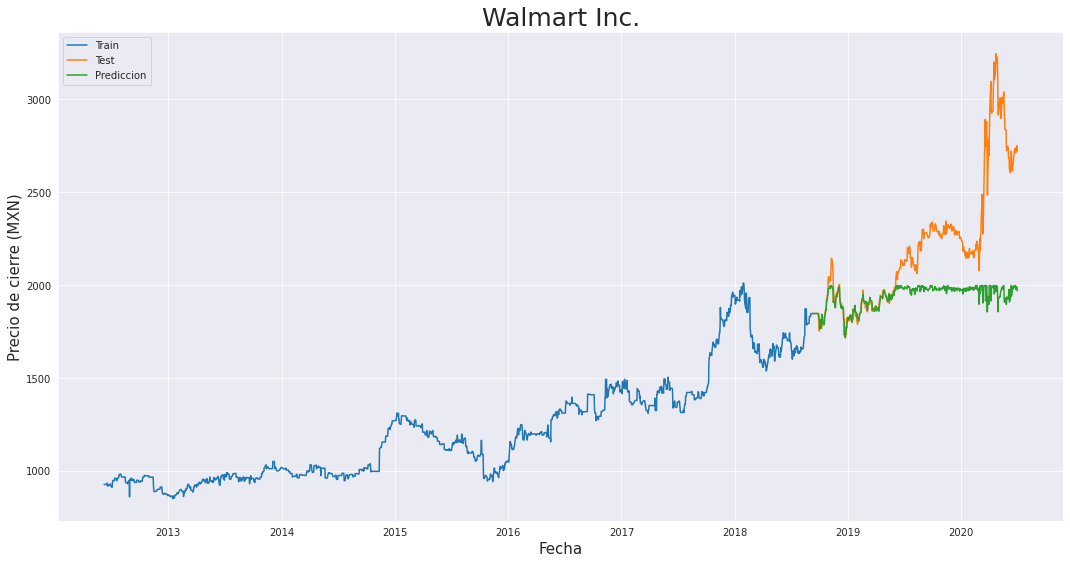

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Walmart Inc.', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

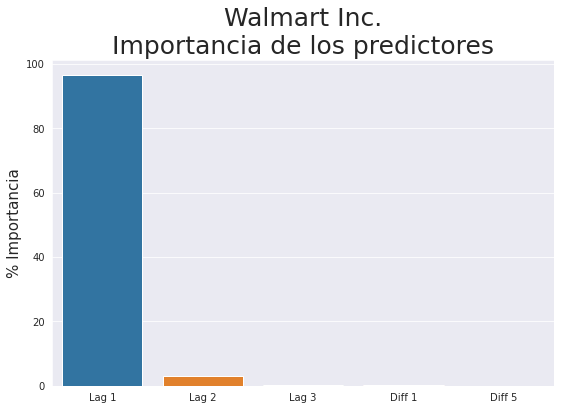

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Walmart Inc.\nImportancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

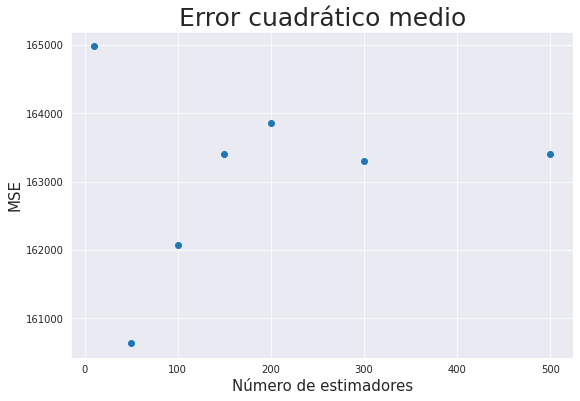

'El número mínimo de estimadores es 50'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

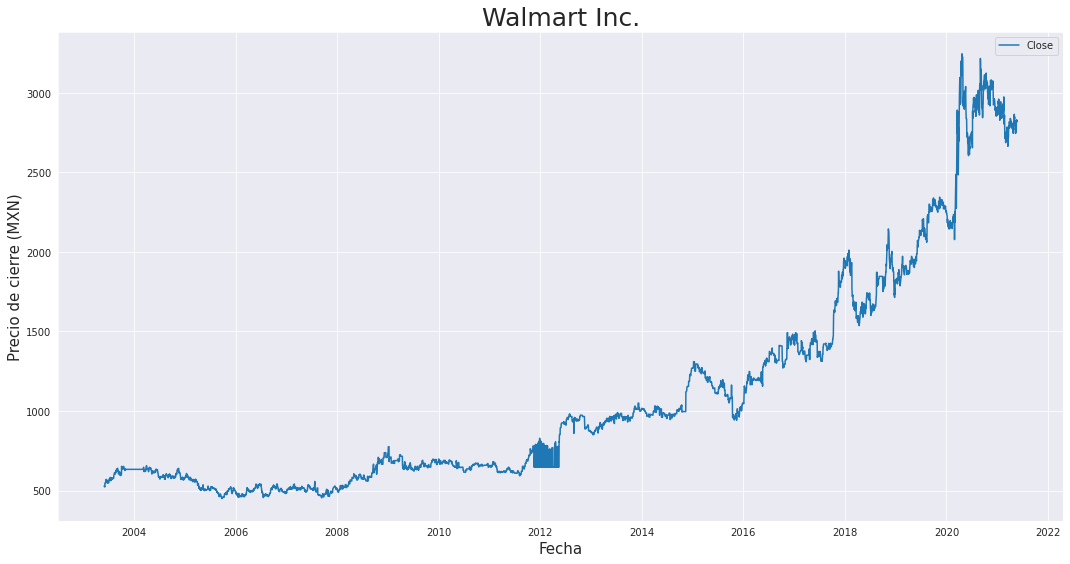

In [ ]:
walmart = info('WMT.MX', 'Close', 'Walmart Inc.')
walmart = walmart.loc['2012-06-01' :]
walmart = predictores(walmart, [1, 2], [])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(walmart, 0.9, 0.1, 0)

In [ ]:
X_train

Lag 1        Lag 2
Date                                
2012-06-05   925.745483   923.474182
2012-06-06   925.735535   925.745483
2012-06-07   925.735535   925.735535
2012-06-08   925.735535   925.735535
2012-06-11   925.735535   925.735535
...                 ...          ...
2020-06-24  2718.095703  2732.824463
2020-06-25  2736.911377  2718.095703
2020-06-26  2712.430420  2736.911377
2020-06-29  2728.428223  2712.430420
2020-06-30  2750.651123  2728.428223

[2022 rows x 2 columns]

In [ ]:
X_test

Lag 1        Lag 2
Date                                
2020-07-01  2721.922852  2750.651123
2020-07-02  2756.896240  2721.922852
2020-07-03  2686.959961  2756.896240
2020-07-06  2686.959961  2686.959961
2020-07-07  2655.413574  2686.959961
...                 ...          ...
2021-05-18  2755.000000  2775.649902
2021-05-19  2826.610107  2755.000000
2021-05-20  2820.000000  2826.610107
2021-05-21  2831.000000  2820.000000
2021-05-24  2827.000000  2831.000000

[225 rows x 2 columns]

In [ ]:
X_val

Empty DataFrame
Columns: [Lag 1, Lag 2]
Index: []

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

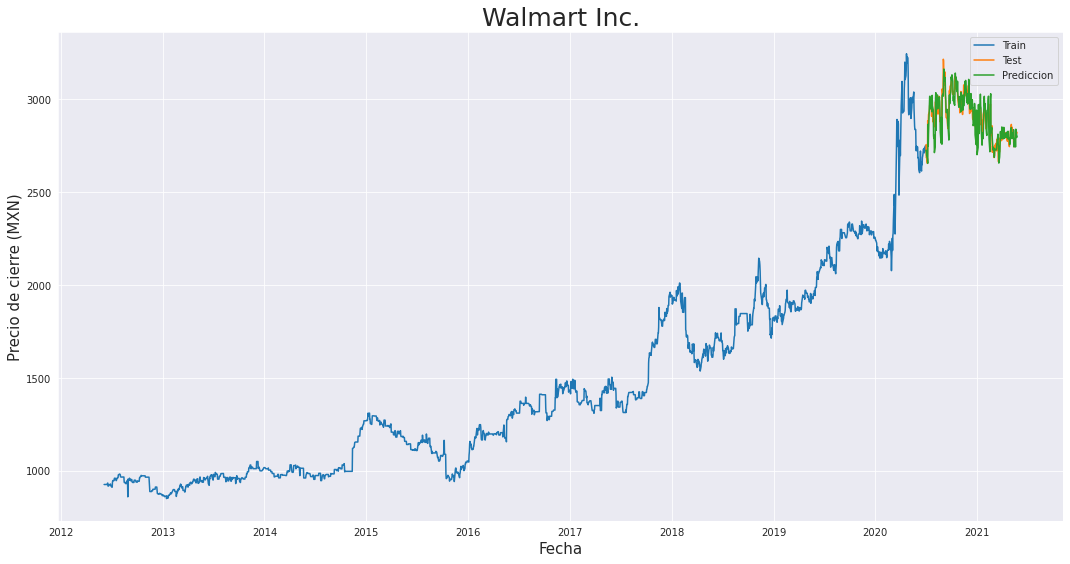

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Walmart Inc.', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

4598.914293820007

In [ ]:
rf_final.score(X_test, y_test)

0.6263293571397675

In [ ]:
walmart.tail()

Close        Lag 1        Lag 2
Date                                             
2021-05-18  2826.610107  2755.000000  2775.649902
2021-05-19  2820.000000  2826.610107  2755.000000
2021-05-20  2831.000000  2820.000000  2826.610107
2021-05-21  2827.000000  2831.000000  2820.000000
2021-05-24  2819.010010  2827.000000  2831.000000

In [ ]:
futuro(walmart, 50, 1, 10)

Close        Lag 1        Lag 2
0  2820.441206  2819.010010  2827.000000
1  2811.357568  2820.441206  2819.010010
2  2801.795010  2811.357568  2820.441206
3  2789.921299  2801.795010  2811.357568
4  2793.071226  2789.921299  2801.795010
5  2778.349219  2793.071226  2789.921299
6  2770.413267  2778.349219  2793.071226
7  2785.941279  2770.413267  2778.349219
8  2797.452759  2785.941279  2770.413267
9  2781.106670  2797.452759  2785.941279

In [ ]:
train = walmart.loc[:'2020-06-29', :]
test = walmart.loc['2020-02-01':'2021-05-01', :]
val = walmart.loc['2021-05-01':, :]

In [ ]:
train

Close        Lag 1        Lag 2
Date                                             
2012-06-05   925.735535   925.745483   923.474182
2012-06-06   925.735535   925.735535   925.745483
2012-06-07   925.735535   925.735535   925.735535
2012-06-08   925.735535   925.735535   925.735535
2012-06-11   925.735535   925.735535   925.735535
...                 ...          ...          ...
2020-06-23  2718.095703  2732.824463  2694.423828
2020-06-24  2736.911377  2718.095703  2732.824463
2020-06-25  2712.430420  2736.911377  2718.095703
2020-06-26  2728.428223  2712.430420  2736.911377
2020-06-29  2750.651123  2728.428223  2712.430420

[2021 rows x 3 columns]

In [ ]:
test

Close        Lag 1        Lag 2
Date                                             
2020-02-04  2176.537598  2169.445801  2172.542236
2020-02-05  2167.547852  2176.537598  2169.445801
2020-02-06  2167.547852  2167.547852  2176.537598
2020-02-07  2184.528809  2167.547852  2167.547852
2020-02-10  2163.052979  2184.528809  2167.547852
...                 ...          ...          ...
2021-04-26  2745.850098  2777.464111  2779.463623
2021-04-27  2775.464355  2745.850098  2777.464111
2021-04-28  2769.455566  2775.464355  2745.850098
2021-04-29  2794.460693  2769.455566  2775.464355
2021-04-30  2827.334229  2794.460693  2769.455566

[311 rows x 3 columns]

In [ ]:
val

Close        Lag 1        Lag 2
Date                                             
2021-05-03  2865.557129  2827.334229  2794.460693
2021-05-04  2837.452393  2865.557129  2827.334229
2021-05-05  2850.449951  2837.452393  2865.557129
2021-05-06  2833.000000  2850.449951  2837.452393
2021-05-07  2798.100098  2833.000000  2850.449951
2021-05-10  2811.810059  2798.100098  2833.000000
2021-05-11  2781.860107  2811.810059  2798.100098
2021-05-12  2745.000000  2781.860107  2811.810059
2021-05-13  2770.000000  2745.000000  2781.860107
2021-05-14  2775.649902  2770.000000  2745.000000
2021-05-17  2755.000000  2775.649902  2770.000000
2021-05-18  2826.610107  2755.000000  2775.649902
2021-05-19  2820.000000  2826.610107  2755.000000
2021-05-20  2831.000000  2820.000000  2826.610107
2021-05-21  2827.000000  2831.000000  2820.000000
2021-05-24  2819.010010  2827.000000  2831.000000

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

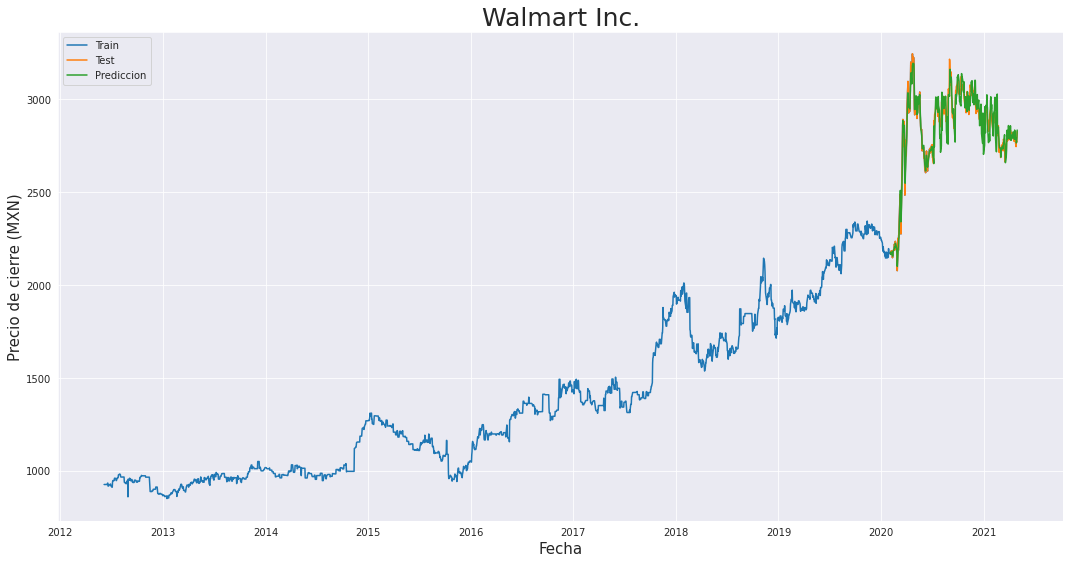

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Walmart Inc.', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

3628.5882155151876

In [ ]:
RF.score(X_test, y_test)

0.9340528847335652

In [ ]:
test.tail()

Close        Lag 1        Lag 2
Date                                             
2021-04-26  2745.850098  2777.464111  2779.463623
2021-04-27  2775.464355  2745.850098  2777.464111
2021-04-28  2769.455566  2775.464355  2745.850098
2021-04-29  2794.460693  2769.455566  2775.464355
2021-04-30  2827.334229  2794.460693  2769.455566

In [ ]:
aux = walmart.loc[:'2021-05-01', :]
fin = futuro(aux, 50, 1, len(y_val))
fin

Close        Lag 1        Lag 2
0   2826.863745  2827.334229  2794.460693
1   2823.447031  2826.863745  2827.334229
2   2810.596362  2823.447031  2826.863745
3   2798.517231  2810.596362  2823.447031
4   2783.990708  2798.517231  2810.596362
5   2807.126431  2783.990708  2798.517231
6   2794.213101  2807.126431  2783.990708
7   2788.497280  2794.213101  2807.126431
8   2793.670532  2788.497280  2794.213101
9   2777.665552  2793.670532  2788.497280
10  2774.516094  2777.665552  2793.670532
11  2785.684629  2774.516094  2777.665552
12  2801.419907  2785.684629  2774.516094
13  2787.079731  2801.419907  2785.684629
14  2806.919019  2787.079731  2801.419907
15  2790.972930  2806.919019  2787.079731

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close        Lag 1        Lag 2
Date                                             
2021-05-03  2826.863745  2827.334229  2794.460693
2021-05-04  2823.447031  2826.863745  2827.334229
2021-05-05  2810.596362  2823.447031  2826.863745
2021-05-06  2798.517231  2810.596362  2823.447031
2021-05-07  2783.990708  2798.517231  2810.596362
2021-05-10  2807.126431  2783.990708  2798.517231
2021-05-11  2794.213101  2807.126431  2783.990708
2021-05-12  2788.497280  2794.213101  2807.126431
2021-05-13  2793.670532  2788.497280  2794.213101
2021-05-14  2777.665552  2793.670532  2788.497280
2021-05-17  2774.516094  2777.665552  2793.670532
2021-05-18  2785.684629  2774.516094  2777.665552
2021-05-19  2801.419907  2785.684629  2774.516094
2021-05-20  2787.079731  2801.419907  2785.684629
2021-05-21  2806.919019  2787.079731  2801.419907
2021-05-24  2790.972930  2806.919019  2787.079731

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close         Pred
Date                                
2021-05-03  2865.557129  2826.863745
2021-05-04  2837.452393  2823.447031
2021-05-05  2850.449951  2810.596362
2021-05-06  2833.000000  2798.517231
2021-05-07  2798.100098  2783.990708
2021-05-10  2811.810059  2807.126431
2021-05-11  2781.860107  2794.213101
2021-05-12  2745.000000  2788.497280
2021-05-13  2770.000000  2793.670532
2021-05-14  2775.649902  2777.665552
2021-05-17  2755.000000  2774.516094
2021-05-18  2826.610107  2785.684629
2021-05-19  2820.000000  2801.419907
2021-05-20  2831.000000  2787.079731
2021-05-21  2827.000000  2806.919019
2021-05-24  2819.010010  2790.972930

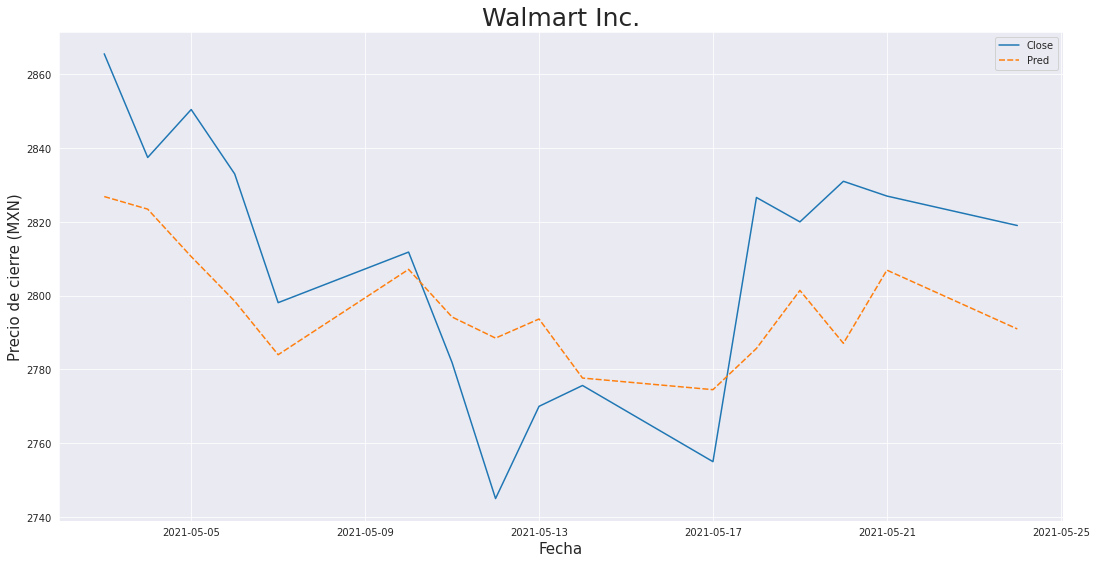

In [ ]:
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('Walmart Inc.', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

801.248887740183

## Fragua

### Obtener informacion

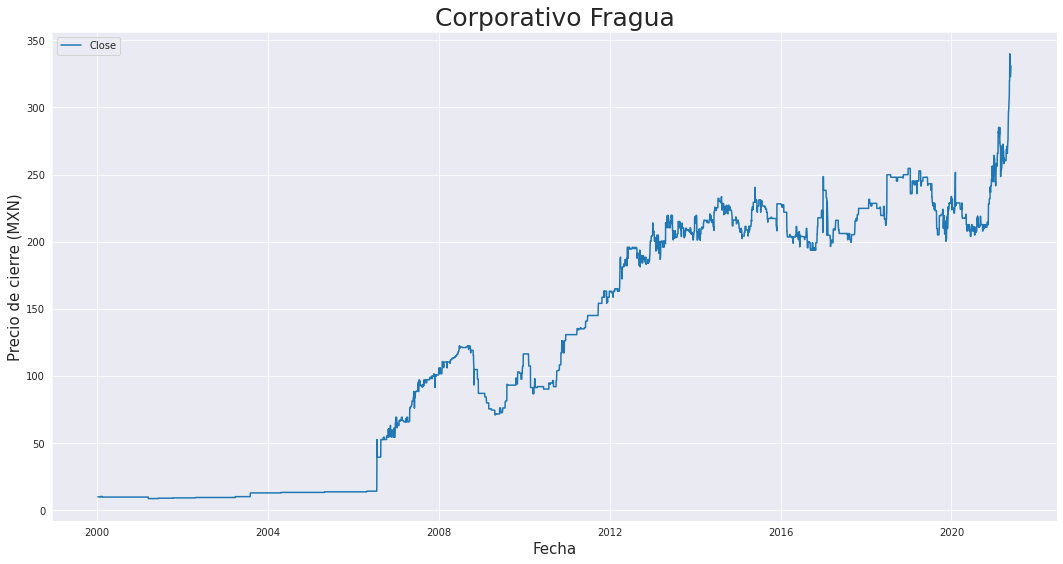

In [ ]:
fragua = info('FRAGUAB.MX', 'Close', 'Corporativo Fragua')

In [ ]:
fragua.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5427 entries, 2000-01-07 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5427 non-null   float64
dtypes: float64(1)
memory usage: 84.8 KB


###Crear predictores

In [ ]:
fragua = predictores(fragua, [1, 2, 3], [1, 5])

In [ ]:
fragua.head()

Close     Lag 1     Lag 2     Lag 3  Diff 1  Diff 5
Date                                                              
2000-01-14  9.761788  9.761788  9.761788  9.761788     0.0     0.0
2000-01-17  9.761788  9.761788  9.761788  9.761788     0.0     0.0
2000-01-18  9.761788  9.761788  9.761788  9.761788     0.0     0.0
2000-01-19  9.761788  9.761788  9.761788  9.761788     0.0     0.0
2000-01-20  9.761788  9.761788  9.761788  9.761788     0.0     0.0

###Seleccion de train, test y validation

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(fragua, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1       Lag 2       Lag 3   Diff 1    Diff 5
Date                                                             
2000-01-14    9.761788    9.761788    9.761788  0.00000  0.000000
2000-01-17    9.761788    9.761788    9.761788  0.00000  0.000000
2000-01-18    9.761788    9.761788    9.761788  0.00000  0.000000
2000-01-19    9.761788    9.761788    9.761788  0.00000  0.000000
2000-01-20    9.761788    9.761788    9.761788  0.00000  0.000000
...                ...         ...         ...      ...       ...
2014-11-21  211.739838  211.739838  211.739838  4.35878 -2.381699
2014-11-24  216.098618  211.739838  211.739838  0.00000  4.358780
2014-11-25  216.098618  216.098618  211.739838  0.00000  4.358780
2014-11-26  216.098618  216.098618  216.098618  0.00000  4.358780
2014-11-27  216.098618  216.098618  216.098618  0.00000  4.358780

[3795 rows x 5 columns]

In [ ]:
X_test

Lag 1       Lag 2       Lag 3  Diff 1    Diff 5
Date                                                            
2014-11-28  216.098618  216.098618  216.098618     0.0  0.000000
2014-12-01  216.098618  216.098618  216.098618     0.0  0.000000
2014-12-02  216.098618  216.098618  216.098618     0.0  0.000000
2014-12-03  216.098618  216.098618  216.098618     0.0  0.000000
2014-12-04  216.098618  216.098618  216.098618     0.0  0.000000
...                ...         ...         ...     ...       ...
2019-03-19  245.165665  240.450943  235.736237     0.0  0.000000
2019-03-20  245.165665  245.165665  240.450943     0.0  0.000000
2019-03-21  245.165665  245.165665  245.165665     0.0  9.429428
2019-03-22  245.165665  245.165665  245.165665     0.0  4.714722
2019-03-25  245.165665  245.165665  245.165665     0.0  0.000000

[1084 rows x 5 columns]

In [ ]:
X_val

Lag 1       Lag 2       Lag 3     Diff 1     Diff 5
Date                                                                
2019-03-26  245.165665  245.165665  245.165665   0.000000   0.000000
2019-03-27  245.165665  245.165665  245.165665   0.000000   0.000000
2019-03-28  245.165665  245.165665  245.165665   0.000000   0.000000
2019-03-29  245.165665  245.165665  245.165665   7.553024   7.553024
2019-04-01  252.718689  245.165665  245.165665   0.000000   7.553024
...                ...         ...         ...        ...        ...
2021-05-18  336.989990  340.000000  321.000000 -11.989990   5.000000
2021-05-19  325.000000  336.989990  340.000000  -2.000000   3.000000
2021-05-20  323.000000  325.000000  336.989990   0.000000   2.000000
2021-05-21  323.000000  323.000000  325.000000   3.100006 -13.899994
2021-05-24  326.100006  323.000000  323.000000   4.899994  -5.989990

[543 rows x 5 columns]

In [ ]:
y_train

Date
2000-01-14      9.761788
2000-01-17      9.761788
2000-01-18      9.761788
2000-01-19      9.761788
2000-01-20      9.761788
                 ...    
2014-11-21    216.098618
2014-11-24    216.098618
2014-11-25    216.098618
2014-11-26    216.098618
2014-11-27    216.098618
Name: Close, Length: 3795, dtype: float64

In [ ]:
y_test

Date
2014-11-28    216.098618
2014-12-01    216.098618
2014-12-02    216.098618
2014-12-03    216.098618
2014-12-04    216.098618
                 ...    
2019-03-19    245.165665
2019-03-20    245.165665
2019-03-21    245.165665
2019-03-22    245.165665
2019-03-25    245.165665
Name: Close, Length: 1084, dtype: float64

In [ ]:
y_val

Date
2019-03-26    245.165665
2019-03-27    245.165665
2019-03-28    245.165665
2019-03-29    252.718689
2019-04-01    252.718689
                 ...    
2021-05-18    325.000000
2021-05-19    323.000000
2021-05-20    323.000000
2021-05-21    326.100006
2021-05-24    331.000000
Name: Close, Length: 543, dtype: float64

### Aplicacion del random forest


In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

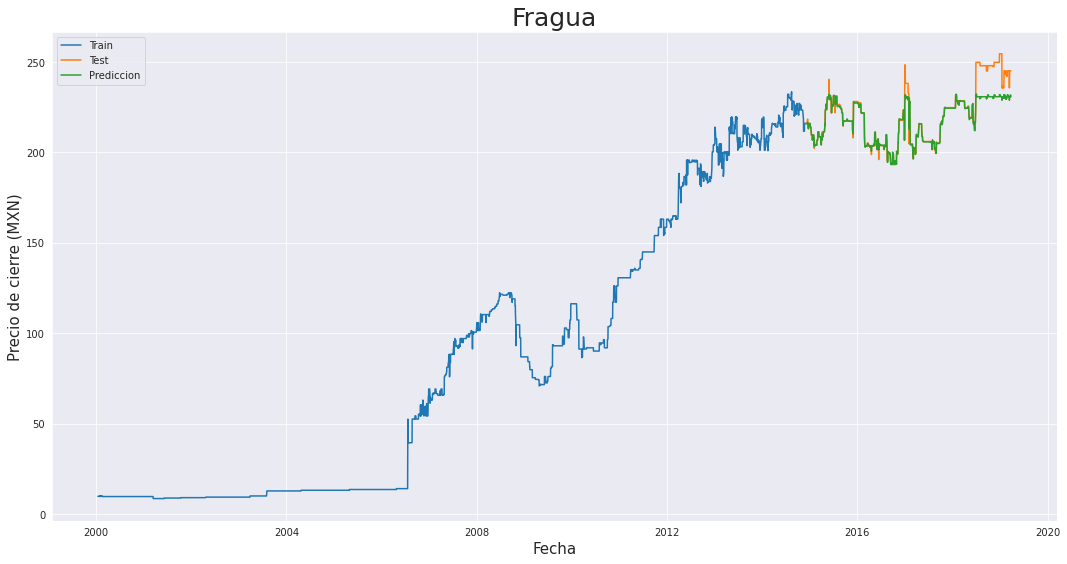

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Fragua', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

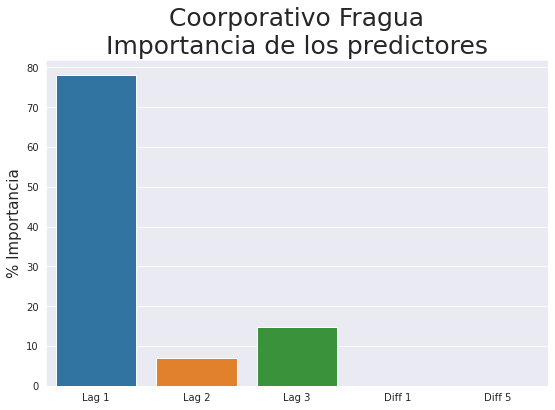

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Coorporativo Fragua\nImportancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

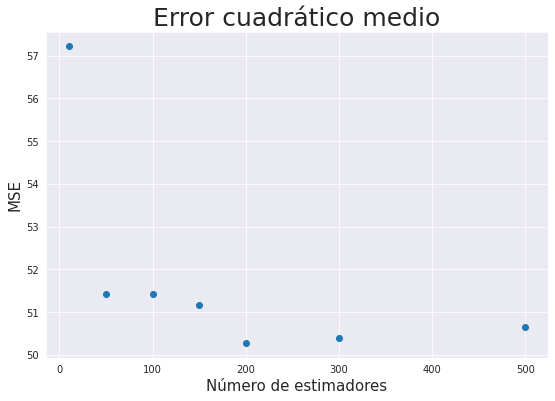

'El número mínimo de estimadores es 200'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

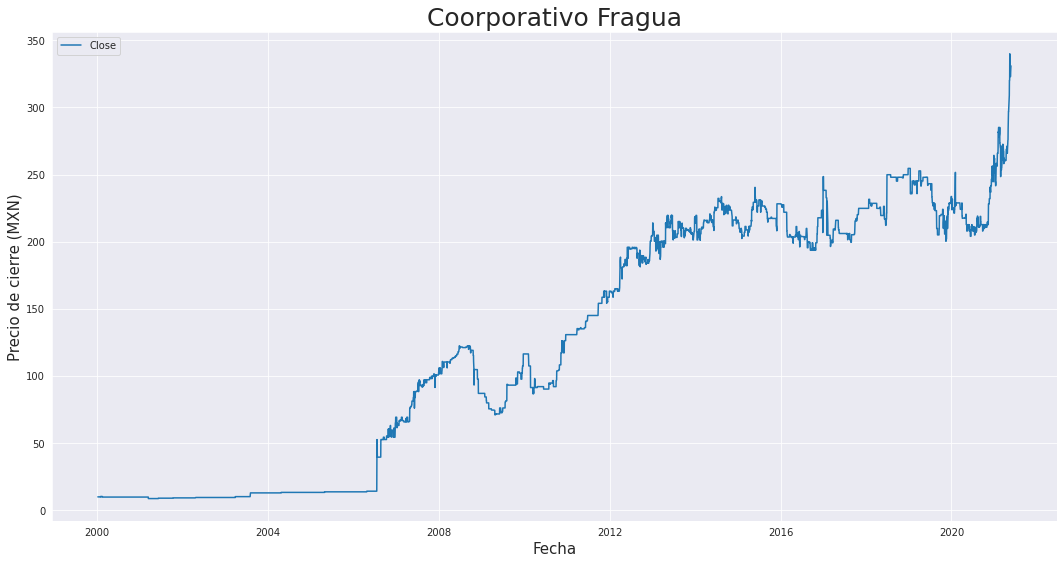

In [ ]:
fragua = info('FRAGUAB.MX', 'Close', 'Coorporativo Fragua')
fragua = predictores(fragua, [1, 2, 3], [])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(fragua, 0.9, 0.1, 0)

In [ ]:
X_train

Lag 1       Lag 2       Lag 3
Date                                          
2000-01-12    9.761788    9.761788    9.761788
2000-01-13    9.761788    9.761788    9.761788
2000-01-14    9.761788    9.761788    9.761788
2000-01-17    9.761788    9.761788    9.761788
2000-01-18    9.761788    9.761788    9.761788
...                ...         ...         ...
2019-03-19  245.165665  240.450943  235.736237
2019-03-20  245.165665  245.165665  240.450943
2019-03-21  245.165665  245.165665  245.165665
2019-03-22  245.165665  245.165665  245.165665
2019-03-25  245.165665  245.165665  245.165665

[4881 rows x 3 columns]

In [ ]:
X_test

Lag 1       Lag 2       Lag 3
Date                                          
2019-03-26  245.165665  245.165665  245.165665
2019-03-27  245.165665  245.165665  245.165665
2019-03-28  245.165665  245.165665  245.165665
2019-03-29  245.165665  245.165665  245.165665
2019-04-01  252.718689  245.165665  245.165665
...                ...         ...         ...
2021-05-18  336.989990  340.000000  321.000000
2021-05-19  325.000000  336.989990  340.000000
2021-05-20  323.000000  325.000000  336.989990
2021-05-21  323.000000  323.000000  325.000000
2021-05-24  326.100006  323.000000  323.000000

[543 rows x 3 columns]

In [ ]:
X_val

Empty DataFrame
Columns: [Lag 1, Lag 2, Lag 3]
Index: []

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 200, random_state = 1)
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

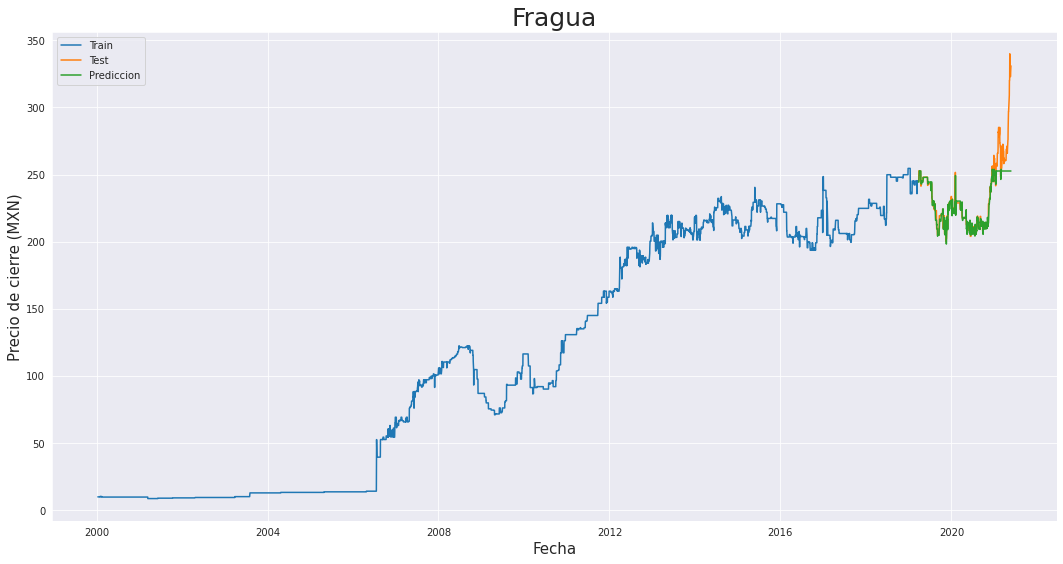

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Fragua', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
fragua[fragua['Close'] == fragua['Close'].max()]

Close  Lag 1  Lag 2  Lag 3
Date                                  
2021-05-14  340.0  321.0  320.0  320.0

El maximo valor del precio de la empresa se alcanza en una fecha muy cercana, por lo que no es viable ajustarlo como en modelos anteriores

In [ ]:
fragua.tail()

Close       Lag 1      Lag 2      Lag 3
Date                                                    
2021-05-18  325.000000  336.989990  340.00000  321.00000
2021-05-19  323.000000  325.000000  336.98999  340.00000
2021-05-20  323.000000  323.000000  325.00000  336.98999
2021-05-21  326.100006  323.000000  323.00000  325.00000
2021-05-24  331.000000  326.100006  323.00000  323.00000

In [ ]:
futuro(fragua, 50, 1, 10)

Close       Lag 1       Lag 2       Lag 3
0  327.763800  331.000000  326.100006  323.000000
1  326.902001  327.763800  331.000000  326.100006
2  326.030001  326.902001  327.763800  331.000000
3  327.084001  326.030001  326.902001  327.763800
4  327.084001  327.084001  326.030001  326.902001
5  327.084001  327.084001  327.084001  326.030001
6  327.084001  327.084001  327.084001  327.084001
7  327.084001  327.084001  327.084001  327.084001
8  327.084001  327.084001  327.084001  327.084001
9  327.084001  327.084001  327.084001  327.084001

In [ ]:
train = fragua.loc[:'2020-02-01', :]
test = fragua.loc['2020-02-01':'2021-05-01', :]
val = fragua.loc['2021-05-01':, :]

In [ ]:
train

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2000-01-12    9.761788    9.761788    9.761788    9.761788
2000-01-13    9.761788    9.761788    9.761788    9.761788
2000-01-14    9.761788    9.761788    9.761788    9.761788
2000-01-17    9.761788    9.761788    9.761788    9.761788
2000-01-18    9.761788    9.761788    9.761788    9.761788
...                ...         ...         ...         ...
2020-01-27  221.230789  221.230789  221.230789  223.166565
2020-01-28  224.091537  221.230789  221.230789  221.230789
2020-01-29  224.091537  224.091537  221.230789  221.230789
2020-01-30  229.402985  224.091537  224.091537  221.230789
2020-01-31  226.237091  229.402985  224.091537  224.091537

[5097 rows x 4 columns]

In [ ]:
test

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2020-02-04  251.626190  226.237091  229.402985  224.091537
2020-02-05  226.952271  251.626190  226.237091  229.402985
2020-02-06  226.952271  226.952271  251.626190  226.237091
2020-02-07  226.952271  226.952271  226.952271  251.626190
2020-02-10  226.952271  226.952271  226.952271  226.952271
...                ...         ...         ...         ...
2021-04-26  272.616455  265.859070  268.701233  268.701233
2021-04-27  274.549927  272.616455  265.859070  268.701233
2021-04-28  275.516632  274.549927  272.616455  265.859070
2021-04-29  276.000000  275.516632  274.549927  272.616455
2021-04-30  284.000000  276.000000  275.516632  274.549927

[311 rows x 4 columns]

In [ ]:
val

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-05-03  297.000000  284.000000  276.000000  275.516632
2021-05-04  297.000000  297.000000  284.000000  276.000000
2021-05-05  300.000000  297.000000  297.000000  284.000000
2021-05-06  301.000000  300.000000  297.000000  297.000000
2021-05-07  303.000000  301.000000  300.000000  297.000000
2021-05-10  309.070007  303.000000  301.000000  300.000000
2021-05-11  320.000000  309.070007  303.000000  301.000000
2021-05-12  320.000000  320.000000  309.070007  303.000000
2021-05-13  321.000000  320.000000  320.000000  309.070007
2021-05-14  340.000000  321.000000  320.000000  320.000000
2021-05-17  336.989990  340.000000  321.000000  320.000000
2021-05-18  325.000000  336.989990  340.000000  321.000000
2021-05-19  323.000000  325.000000  336.989990  340.000000
2021-05-20  323.000000  323.000000  325.000000  336.989990
2021-05-21  326.100006  323.000000  323.000000  325.000000
2021-05-24  331.000000  326.100006  323.000000  323.000000

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

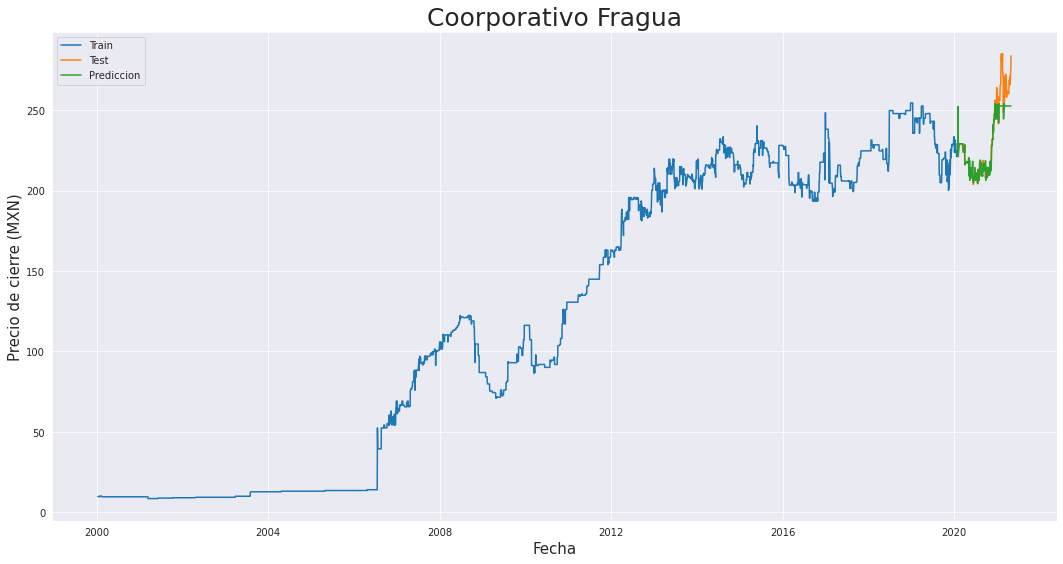

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Coorporativo Fragua', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

78.24670523992393

In [ ]:
RF.score(X_test, y_test)

0.857559794303174

In [ ]:
test.tail()

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-04-26  272.616455  265.859070  268.701233  268.701233
2021-04-27  274.549927  272.616455  265.859070  268.701233
2021-04-28  275.516632  274.549927  272.616455  265.859070
2021-04-29  276.000000  275.516632  274.549927  272.616455
2021-04-30  284.000000  276.000000  275.516632  274.549927

In [ ]:
aux = fragua.loc[:'2021-05-01', :]
fin = futuro(aux, 50, 1, len(y_val))
fin

Close       Lag 1       Lag 2       Lag 3
0   280.906951  284.000000  276.000000  275.516632
1   283.557606  280.906951  284.000000  276.000000
2   281.085554  283.557606  280.906951  284.000000
3   282.941282  281.085554  283.557606  280.906951
4   281.462189  282.941282  281.085554  283.557606
5   283.617991  281.462189  282.941282  281.085554
6   280.689196  283.617991  281.462189  282.941282
7   283.095959  280.689196  283.617991  281.462189
8   281.172751  283.095959  280.689196  283.617991
9   283.164211  281.172751  283.095959  280.689196
10  281.152836  283.164211  281.172751  283.095959
11  283.637325  281.152836  283.164211  281.172751
12  280.650527  283.637325  281.152836  283.164211
13  283.095959  280.650527  283.637325  281.152836
14  281.172751  283.095959  280.650527  283.637325
15  283.164211  281.172751  283.095959  280.650527

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close       Lag 1       Lag 2       Lag 3
Date                                                      
2021-05-03  280.906951  284.000000  276.000000  275.516632
2021-05-04  283.557606  280.906951  284.000000  276.000000
2021-05-05  281.085554  283.557606  280.906951  284.000000
2021-05-06  282.941282  281.085554  283.557606  280.906951
2021-05-07  281.462189  282.941282  281.085554  283.557606
2021-05-10  283.617991  281.462189  282.941282  281.085554
2021-05-11  280.689196  283.617991  281.462189  282.941282
2021-05-12  283.095959  280.689196  283.617991  281.462189
2021-05-13  281.172751  283.095959  280.689196  283.617991
2021-05-14  283.164211  281.172751  283.095959  280.689196
2021-05-17  281.152836  283.164211  281.172751  283.095959
2021-05-18  283.637325  281.152836  283.164211  281.172751
2021-05-19  280.650527  283.637325  281.152836  283.164211
2021-05-20  283.095959  280.650527  283.637325  281.152836
2021-05-21  281.172751  283.095959  280.650527  283.637325
2021-05-24  283.164211  281.172751  283.095959  280.650527

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close        Pred
Date                              
2021-05-03  297.000000  280.906951
2021-05-04  297.000000  283.557606
2021-05-05  300.000000  281.085554
2021-05-06  301.000000  282.941282
2021-05-07  303.000000  281.462189
2021-05-10  309.070007  283.617991
2021-05-11  320.000000  280.689196
2021-05-12  320.000000  283.095959
2021-05-13  321.000000  281.172751
2021-05-14  340.000000  283.164211
2021-05-17  336.989990  281.152836
2021-05-18  325.000000  283.637325
2021-05-19  323.000000  280.650527
2021-05-20  323.000000  283.095959
2021-05-21  326.100006  281.172751
2021-05-24  331.000000  283.164211

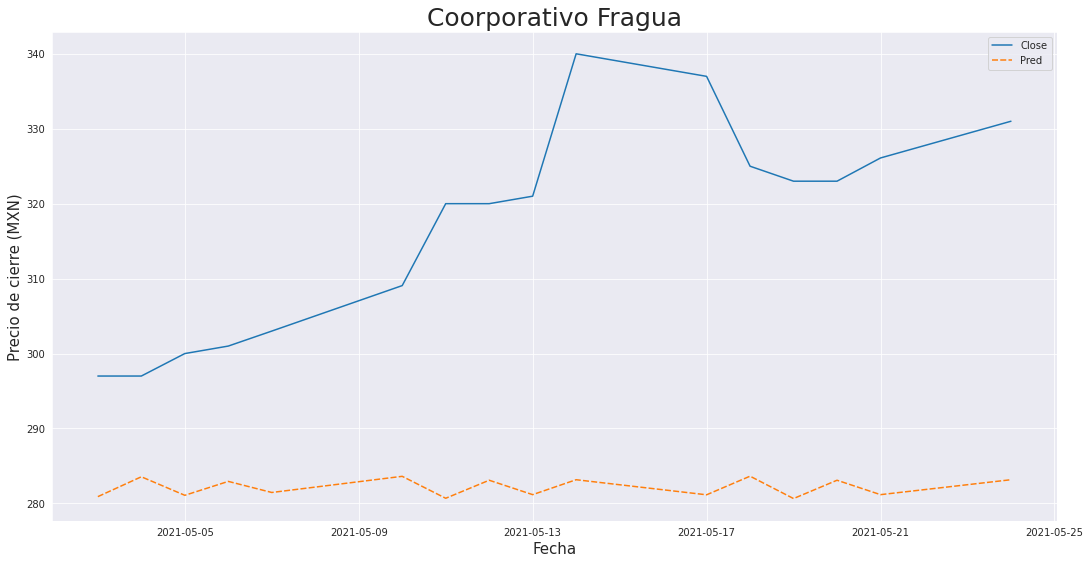

In [ ]:
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('Coorporativo Fragua', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

1405.012141353841

## American Movil

### Obteniendo informacion

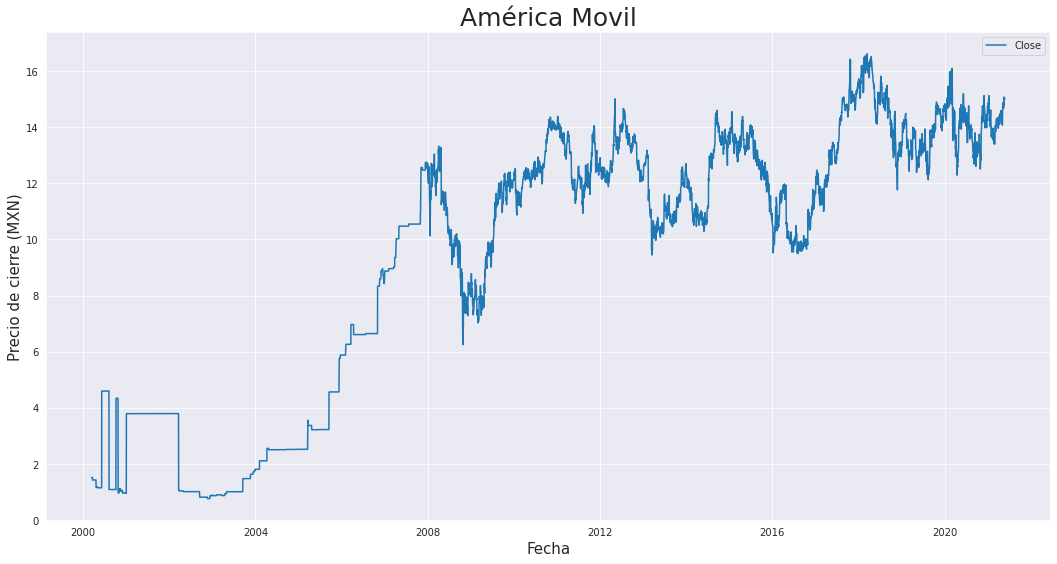

In [ ]:
a_movil = info("AMXL.MX","Close","América Movil")

In [ ]:
a_movil = a_movil["2008-01-02":]
a_movil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3358 entries, 2008-01-02 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3358 non-null   float64
dtypes: float64(1)
memory usage: 52.5 KB


### Crear predictores

In [ ]:
a_movil_pred = predictores(a_movil, [1, 2, 3], [1, 5])

In [ ]:
a_movil_pred.head()

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966

### Seleccion de train, test y validation

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(a_movil_pred, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2008-01-09  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...       ...       ...
2017-05-16  13.198915  12.904216  12.841705 -0.035723 -0.008932
2017-05-17  13.163193  13.198915  12.904216 -0.178604 -0.205397
2017-05-18  12.984589  13.163193  13.198915 -0.321489 -0.178606
2017-05-19  12.663099  12.984589  13.163193  0.535816  0.294700
2017-05-22  13.198915  12.663099  12.984589 -0.044651 -0.044651

[2347 rows x 5 columns]

In [ ]:
X_test

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2017-05-23  13.154264  13.198915  12.663099  0.053580  0.044652
2017-05-24  13.207845  13.154264  13.198915  0.116094  0.339350
2017-05-25  13.323938  13.207845  13.154264 -0.062511  0.598328
2017-05-26  13.261427  13.323938  13.207845  0.196466  0.258978
2017-05-29  13.457893  13.261427  13.323938 -0.080374  0.223255
...               ...        ...        ...       ...       ...
2020-01-14  14.425322  14.473247  14.420529 -0.134191 -0.162945
2020-01-15  14.291131  14.425322  14.473247 -0.057508 -0.134189
2020-01-16  14.233623  14.291131  14.425322  0.440907  0.254000
2020-01-17  14.674529  14.233623  14.291131  0.182114  0.383396
2020-01-20  14.856643  14.674529  14.233623  0.009585  0.440907

[670 rows x 5 columns]

In [ ]:
X_val

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2020-01-21  14.866228  14.856643  14.674529  0.076679  0.651776
2020-01-22  14.942907  14.866228  14.856643 -0.076679  0.632606
2020-01-23  14.866228  14.942907  14.866228  0.182114  0.373813
2020-01-24  15.048342  14.866228  14.942907 -0.019170  0.172529
2020-01-27  15.029172  15.048342  14.866228 -0.354643 -0.191699
...               ...        ...        ...       ...       ...
2021-05-18  14.790000  14.670000  14.760000  0.110000  0.030000
2021-05-19  14.900000  14.790000  14.670000 -0.099999  0.060000
2021-05-20  14.800000  14.900000  14.790000  0.270000  0.309999
2021-05-21  15.070000  14.800000  14.900000 -0.099999  0.300000
2021-05-24  14.970000  15.070000  14.800000  0.070000  0.250000

[336 rows x 5 columns]

In [ ]:
y_train

Date
2008-01-09    12.260990
2008-01-10    12.591238
2008-01-11    12.321725
2008-01-14    12.147110
2008-01-15    11.801676
                ...    
2017-05-16    13.163193
2017-05-17    12.984589
2017-05-18    12.663099
2017-05-19    13.198915
2017-05-22    13.154264
Name: Close, Length: 2347, dtype: float64

In [ ]:
y_test

Date
2017-05-23    13.207845
2017-05-24    13.323938
2017-05-25    13.261427
2017-05-26    13.457893
2017-05-29    13.377520
                ...    
2020-01-14    14.291131
2020-01-15    14.233623
2020-01-16    14.674529
2020-01-17    14.856643
2020-01-20    14.866228
Name: Close, Length: 670, dtype: float64

In [ ]:
y_val

Date
2020-01-21    14.942907
2020-01-22    14.866228
2020-01-23    15.048342
2020-01-24    15.029172
2020-01-27    14.674529
                ...    
2021-05-18    14.900000
2021-05-19    14.800000
2021-05-20    15.070000
2021-05-21    14.970000
2021-05-24    15.040000
Name: Close, Length: 336, dtype: float64

### Aplicacion del random forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

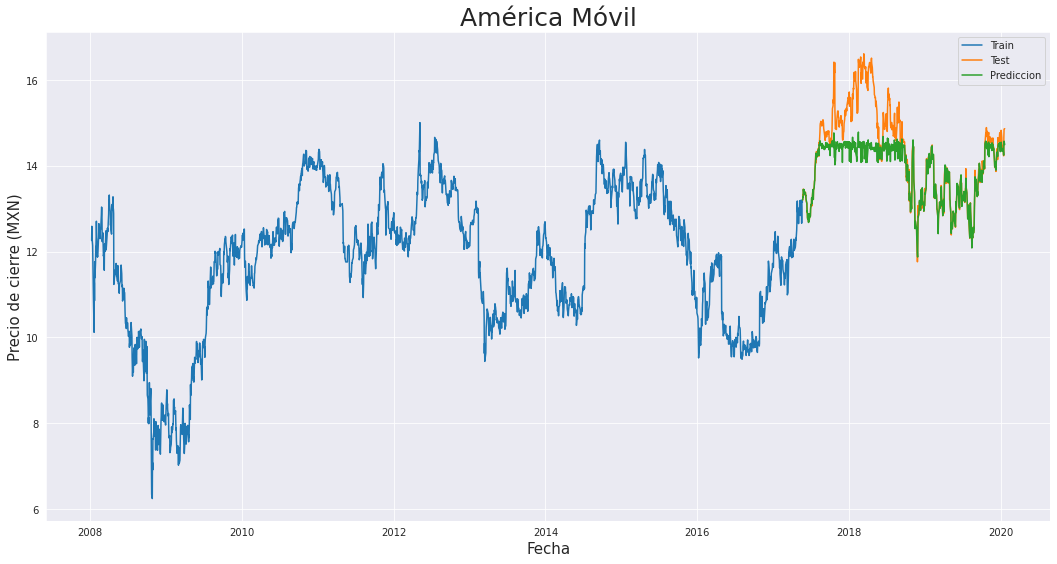

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('América Móvil', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

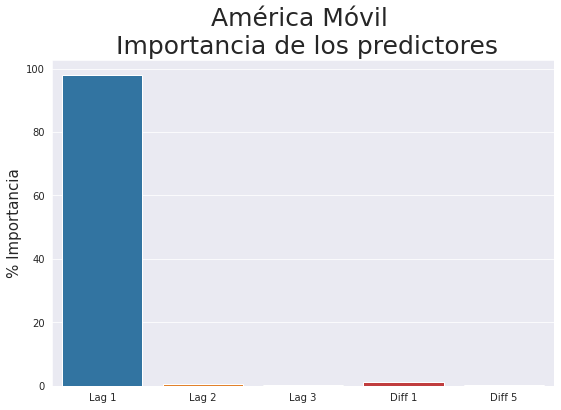

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('América Móvil \n Importancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

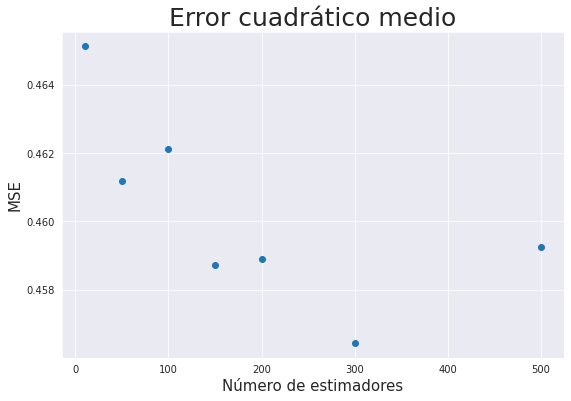

'El número mínimo de estimadores es 300'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

In [ ]:
a_movil_pred_1 = predictores(a_movil,[1,2],[1])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(a_movil_pred_1, 0.9, 0.1, 0)

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 300, random_state = 1)

In [ ]:
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

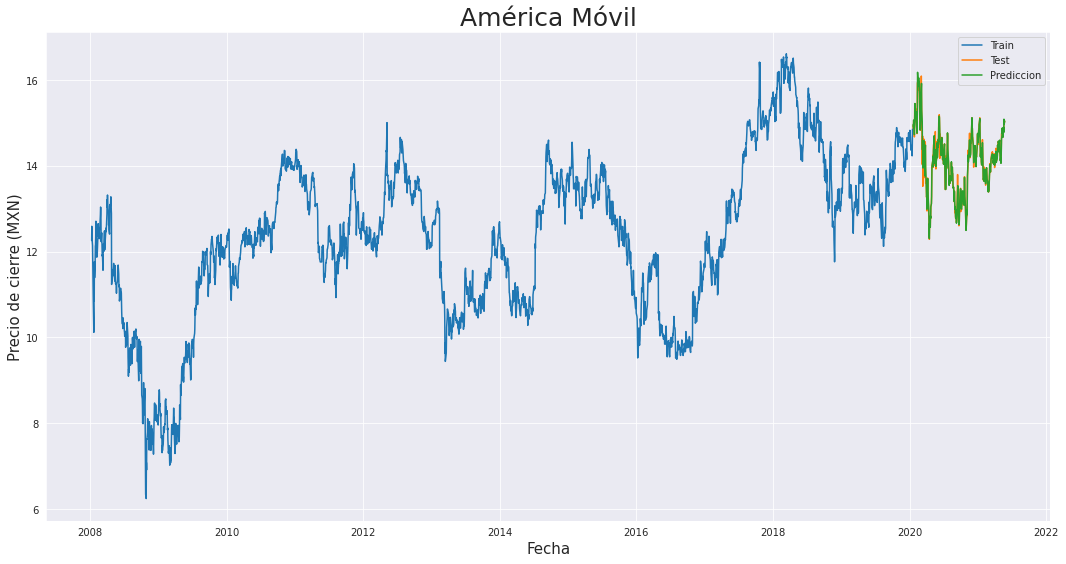

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('América Móvil', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.011235152896195224

In [ ]:
rf_final.score(X_test, y_test)

0.9789897453667865

In [ ]:
a_movil_pred_1.tail()

Close  Lag 1  Lag 2  Lag 3    Diff 1    Diff 5
Date                                                      
2021-05-18  14.90  14.79  14.67  14.76  0.110000  0.030000
2021-05-19  14.80  14.90  14.79  14.67 -0.099999  0.060000
2021-05-20  15.07  14.80  14.90  14.79  0.270000  0.309999
2021-05-21  14.97  15.07  14.80  14.90 -0.099999  0.300000
2021-05-24  15.04  14.97  15.07  14.80  0.070000  0.250000

In [ ]:
train = a_movil_pred_1.loc[:'2020-02-01', :]
test = a_movil_pred_1.loc['2020-02-01':'2021-05-01', :]
val = a_movil_pred_1.loc['2021-05-01':, :]

In [ ]:
train

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...        ...       ...       ...
2020-01-27  14.674529  15.029172  15.048342  14.866228 -0.354643 -0.191699
2020-01-28  15.077096  14.674529  15.029172  15.048342  0.402567  0.134189
2020-01-29  15.450910  15.077096  14.674529  15.029172  0.373814  0.584682
2020-01-30  15.393399  15.450910  15.077096  14.674529 -0.057510  0.345057
2020-01-31  15.043549  15.393399  15.450910  15.077096 -0.349851  0.014377

[3026 rows x 6 columns]

In [ ]:
test

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2020-02-04  15.326303  15.043549  15.393399  15.450910  0.282755  0.651774
2020-02-05  15.230456  15.326303  15.043549  15.393399 -0.095847  0.153360
2020-02-06  15.029172  15.230456  15.326303  15.043549 -0.201284 -0.421738
2020-02-07  14.990833  15.029172  15.230456  15.326303 -0.038339 -0.402566
2020-02-10  14.751209  14.990833  15.029172  15.230456 -0.239624 -0.292339
...               ...        ...        ...        ...       ...       ...
2021-04-26  14.570000  14.500000  14.560000  14.500000  0.070000  0.230000
2021-04-27  14.590000  14.570000  14.500000  14.560000  0.020000  0.020000
2021-04-28  14.300000  14.590000  14.570000  14.500000 -0.290000 -0.200000
2021-04-29  14.310000  14.300000  14.590000  14.570000  0.010000 -0.250000
2021-04-30  14.150000  14.310000  14.300000  14.590000 -0.160001 -0.350000

[311 rows x 6 columns]

In [ ]:
val

Close  Lag 1  Lag 2  Lag 3    Diff 1    Diff 5
Date                                                      
2021-05-03  14.17  14.15  14.31  14.30  0.020000 -0.400000
2021-05-04  14.07  14.17  14.15  14.31 -0.100000 -0.520000
2021-05-05  14.16  14.07  14.17  14.15  0.090000 -0.140000
2021-05-06  14.45  14.16  14.07  14.17  0.290000  0.139999
2021-05-07  14.75  14.45  14.16  14.07  0.300000  0.600000
2021-05-10  14.74  14.75  14.45  14.16 -0.010000  0.570000
2021-05-11  14.87  14.74  14.75  14.45  0.130000  0.800000
2021-05-12  14.74  14.87  14.74  14.75 -0.130000  0.580000
2021-05-13  14.76  14.74  14.87  14.74  0.020000  0.310000
2021-05-14  14.67  14.76  14.74  14.87 -0.090000 -0.080000
2021-05-17  14.79  14.67  14.76  14.74  0.120000  0.050000
2021-05-18  14.90  14.79  14.67  14.76  0.110000  0.030000
2021-05-19  14.80  14.90  14.79  14.67 -0.099999  0.060000
2021-05-20  15.07  14.80  14.90  14.79  0.270000  0.309999
2021-05-21  14.97  15.07  14.80  14.90 -0.099999  0.300000
2021-05-24  15.04  14.97  15.07  14.80  0.070000  0.250000

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=300, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

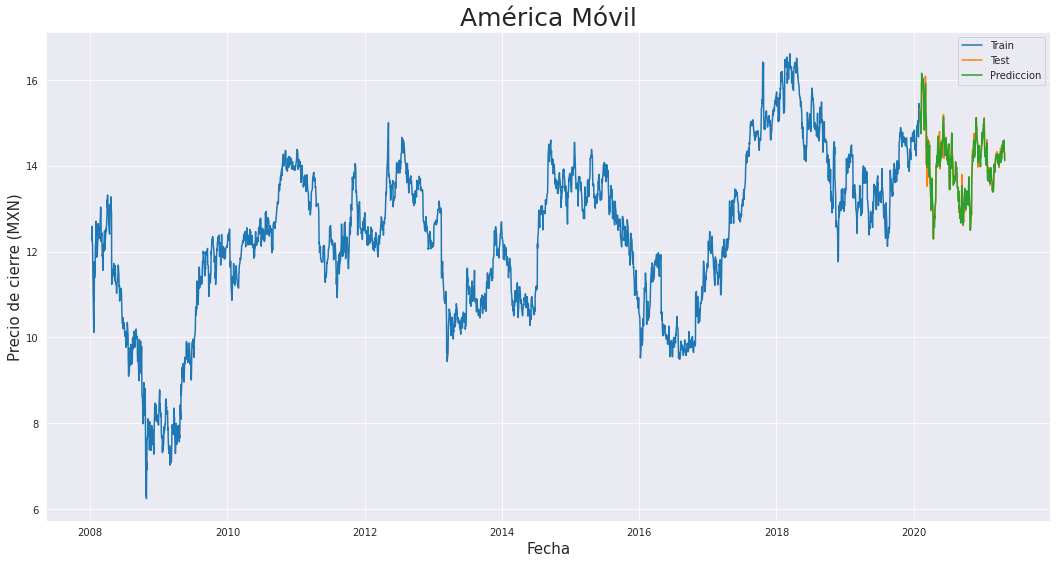

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('América Móvil', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.011585607695199176

In [ ]:
RF.score(X_test, y_test)

0.9778817079334268

In [ ]:
aux = a_movil_pred_1.loc[:'2021-05-01', :]
aux

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...        ...       ...       ...
2021-04-26  14.570000  14.500000  14.560000  14.500000  0.070000  0.230000
2021-04-27  14.590000  14.570000  14.500000  14.560000  0.020000  0.020000
2021-04-28  14.300000  14.590000  14.570000  14.500000 -0.290000 -0.200000
2021-04-29  14.310000  14.300000  14.590000  14.570000  0.010000 -0.250000
2021-04-30  14.150000  14.310000  14.300000  14.590000 -0.160001 -0.350000

[3337 rows x 6 columns]

In [ ]:
fin = futuro(aux, 50, 1, len(y_val))
fin

Close      Lag 1      Lag 2      Lag 3     Diff 1     Diff 5
0   14.699507  14.150000  14.310000  14.300000  14.590000  -0.160001
1   15.074059  14.699507  14.150000  14.310000  14.300000  14.590000
2   15.722027  15.074059  14.699507  14.150000  14.310000  14.300000
3   16.207680  15.722027  15.074059  14.699507  14.150000  14.310000
4   16.392474  16.207680  15.722027  15.074059  14.699507  14.150000
5   16.466249  16.392474  16.207680  15.722027  15.074059  14.699507
6   16.533079  16.466249  16.392474  16.207680  15.722027  15.074059
7   16.556485  16.533079  16.466249  16.392474  16.207680  15.722027
8   16.542161  16.556485  16.533079  16.466249  16.392474  16.207680
9   16.525448  16.542161  16.556485  16.533079  16.466249  16.392474
10  16.525448  16.525448  16.542161  16.556485  16.533079  16.466249
11  16.525448  16.525448  16.525448  16.542161  16.556485  16.533079
12  16.525448  16.525448  16.525448  16.525448  16.542161  16.556485
13  16.525448  16.525448  16.525448  16.525448  16.525448  16.542161
14  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
15  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close      Lag 1      Lag 2      Lag 3     Diff 1     Diff 5
Date                                                                        
2021-05-03  14.699507  14.150000  14.310000  14.300000  14.590000  -0.160001
2021-05-04  15.074059  14.699507  14.150000  14.310000  14.300000  14.590000
2021-05-05  15.722027  15.074059  14.699507  14.150000  14.310000  14.300000
2021-05-06  16.207680  15.722027  15.074059  14.699507  14.150000  14.310000
2021-05-07  16.392474  16.207680  15.722027  15.074059  14.699507  14.150000
2021-05-10  16.466249  16.392474  16.207680  15.722027  15.074059  14.699507
2021-05-11  16.533079  16.466249  16.392474  16.207680  15.722027  15.074059
2021-05-12  16.556485  16.533079  16.466249  16.392474  16.207680  15.722027
2021-05-13  16.542161  16.556485  16.533079  16.466249  16.392474  16.207680
2021-05-14  16.525448  16.542161  16.556485  16.533079  16.466249  16.392474
2021-05-17  16.525448  16.525448  16.542161  16.556485  16.533079  16.466249
2021-05-18  16.525448  16.525448  16.525448  16.542161  16.556485  16.533079
2021-05-19  16.525448  16.525448  16.525448  16.525448  16.542161  16.556485
2021-05-20  16.525448  16.525448  16.525448  16.525448  16.525448  16.542161
2021-05-21  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
2021-05-24  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close       Pred
Date                        
2021-05-03  14.17  14.699507
2021-05-04  14.07  15.074059
2021-05-05  14.16  15.722027
2021-05-06  14.45  16.207680
2021-05-07  14.75  16.392474
2021-05-10  14.74  16.466249
2021-05-11  14.87  16.533079
2021-05-12  14.74  16.556485
2021-05-13  14.76  16.542161
2021-05-14  14.67  16.525448
2021-05-17  14.79  16.525448
2021-05-18  14.90  16.525448
2021-05-19  14.80  16.525448
2021-05-20  15.07  16.525448
2021-05-21  14.97  16.525448
2021-05-24  15.04  16.525448

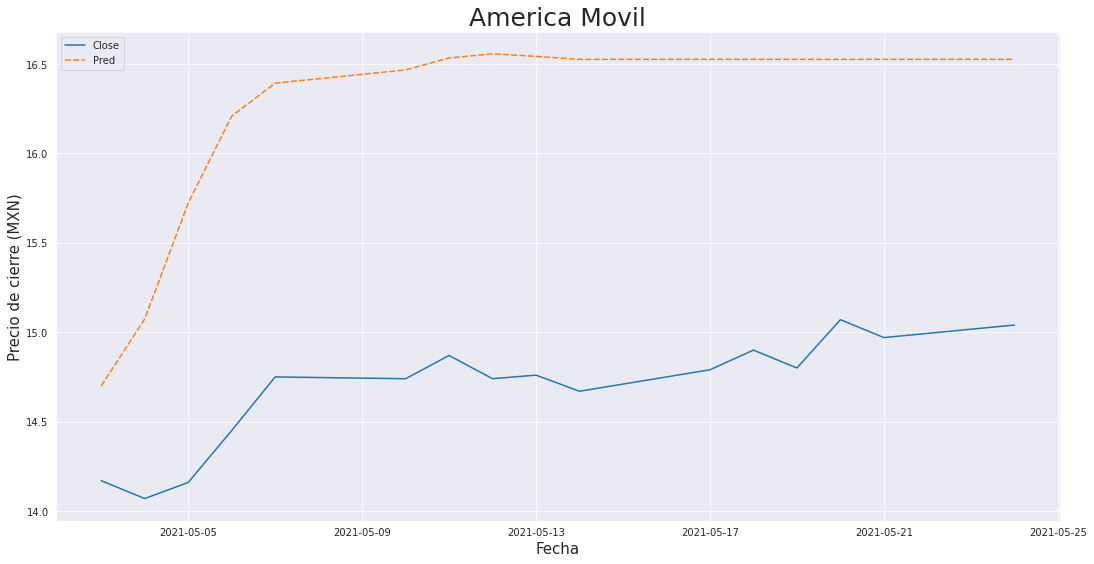

In [ ]:
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('America Movil', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

2.5346943641424216

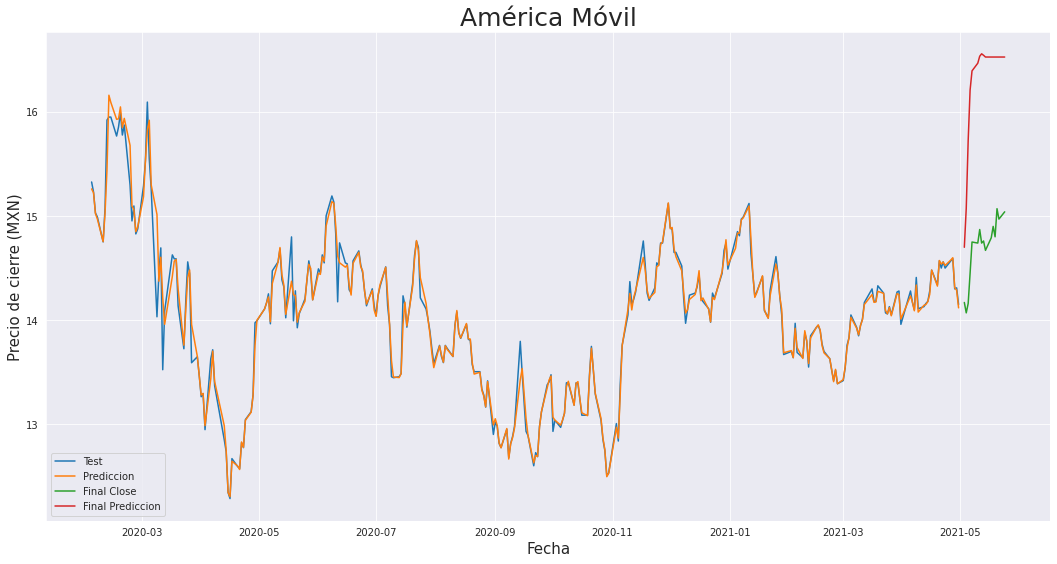

In [ ]:
plt.figure(figsize=(18,9))

# plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')
plt.plot(comp.index, comp['Close'], label='Final Close')
plt.plot(comp.index, comp['Pred'], label='Final Prediccion')

plt.title('América Móvil', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

## Banorte

### Obteniendo informacion

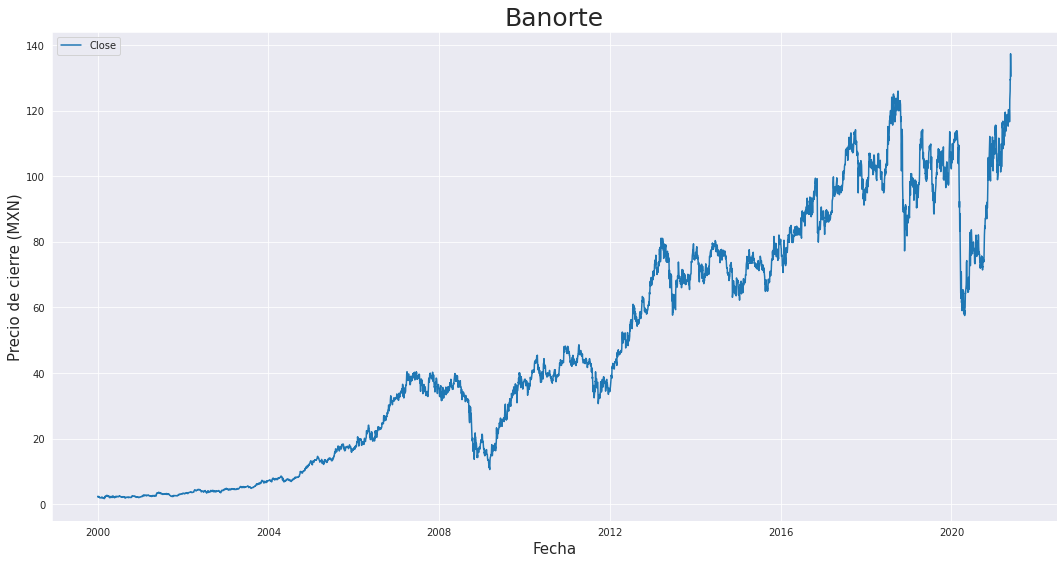

In [ ]:
banorte = info("GFNORTEO.MX","Close","Banorte")

In [ ]:
banorte.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5363 entries, 2000-01-03 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5363 non-null   float64
dtypes: float64(1)
memory usage: 83.8 KB


### Crear predictores

In [ ]:
banorte_pred = predictores(a_movil, [1, 2, 3], [1, 5])

In [ ]:
banorte_pred.head()

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966

### Seleccion de train, test y validation

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(banorte_pred, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2008-01-09  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...       ...       ...
2017-05-16  13.198915  12.904216  12.841705 -0.035723 -0.008932
2017-05-17  13.163193  13.198915  12.904216 -0.178604 -0.205397
2017-05-18  12.984589  13.163193  13.198915 -0.321489 -0.178606
2017-05-19  12.663099  12.984589  13.163193  0.535816  0.294700
2017-05-22  13.198915  12.663099  12.984589 -0.044651 -0.044651

[2347 rows x 5 columns]

In [ ]:
X_test

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2017-05-23  13.154264  13.198915  12.663099  0.053580  0.044652
2017-05-24  13.207845  13.154264  13.198915  0.116094  0.339350
2017-05-25  13.323938  13.207845  13.154264 -0.062511  0.598328
2017-05-26  13.261427  13.323938  13.207845  0.196466  0.258978
2017-05-29  13.457893  13.261427  13.323938 -0.080374  0.223255
...               ...        ...        ...       ...       ...
2020-01-14  14.425322  14.473247  14.420529 -0.134191 -0.162945
2020-01-15  14.291131  14.425322  14.473247 -0.057508 -0.134189
2020-01-16  14.233623  14.291131  14.425322  0.440907  0.254000
2020-01-17  14.674529  14.233623  14.291131  0.182114  0.383396
2020-01-20  14.856643  14.674529  14.233623  0.009585  0.440907

[670 rows x 5 columns]

In [ ]:
X_val

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2020-01-21  14.866228  14.856643  14.674529  0.076679  0.651776
2020-01-22  14.942907  14.866228  14.856643 -0.076679  0.632606
2020-01-23  14.866228  14.942907  14.866228  0.182114  0.373813
2020-01-24  15.048342  14.866228  14.942907 -0.019170  0.172529
2020-01-27  15.029172  15.048342  14.866228 -0.354643 -0.191699
...               ...        ...        ...       ...       ...
2021-05-18  14.790000  14.670000  14.760000  0.110000  0.030000
2021-05-19  14.900000  14.790000  14.670000 -0.099999  0.060000
2021-05-20  14.800000  14.900000  14.790000  0.270000  0.309999
2021-05-21  15.070000  14.800000  14.900000 -0.099999  0.300000
2021-05-24  14.970000  15.070000  14.800000  0.070000  0.250000

[336 rows x 5 columns]

In [ ]:
y_train

Date
2008-01-09    12.260990
2008-01-10    12.591238
2008-01-11    12.321725
2008-01-14    12.147110
2008-01-15    11.801676
                ...    
2017-05-16    13.163193
2017-05-17    12.984589
2017-05-18    12.663099
2017-05-19    13.198915
2017-05-22    13.154264
Name: Close, Length: 2347, dtype: float64

In [ ]:
y_test

Date
2017-05-23    13.207845
2017-05-24    13.323938
2017-05-25    13.261427
2017-05-26    13.457893
2017-05-29    13.377520
                ...    
2020-01-14    14.291131
2020-01-15    14.233623
2020-01-16    14.674529
2020-01-17    14.856643
2020-01-20    14.866228
Name: Close, Length: 670, dtype: float64

In [ ]:
y_val

Date
2020-01-21    14.942907
2020-01-22    14.866228
2020-01-23    15.048342
2020-01-24    15.029172
2020-01-27    14.674529
                ...    
2021-05-18    14.900000
2021-05-19    14.800000
2021-05-20    15.070000
2021-05-21    14.970000
2021-05-24    15.040000
Name: Close, Length: 336, dtype: float64

### Aplicacion del Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

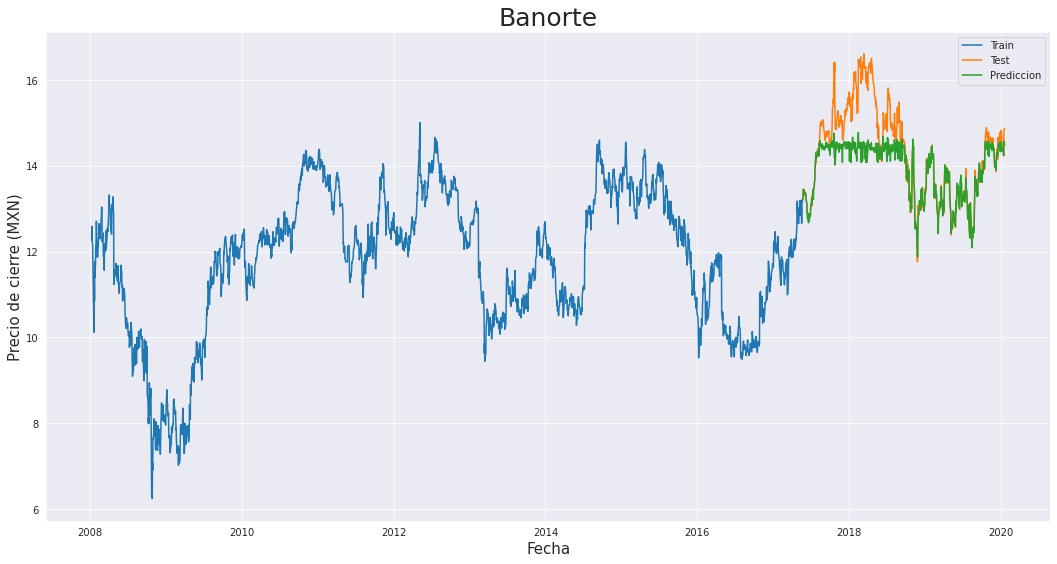

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Banorte', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

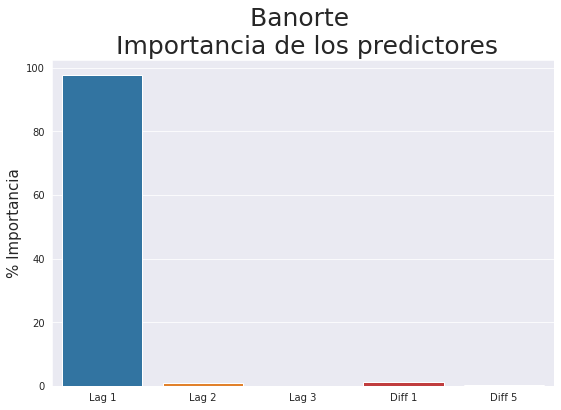

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Banorte \n Importancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

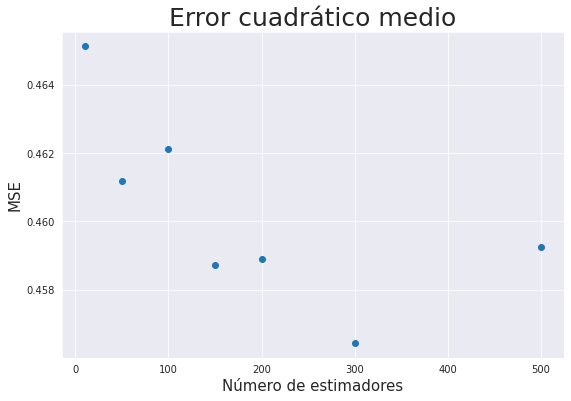

'El número mínimo de estimadores es 300'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

In [ ]:
banorte_pred_1 = predictores(banorte,[1,2],[1])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(banorte_pred_1, 0.9, 0.1, 0)

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 300, random_state = 1)

In [ ]:
rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

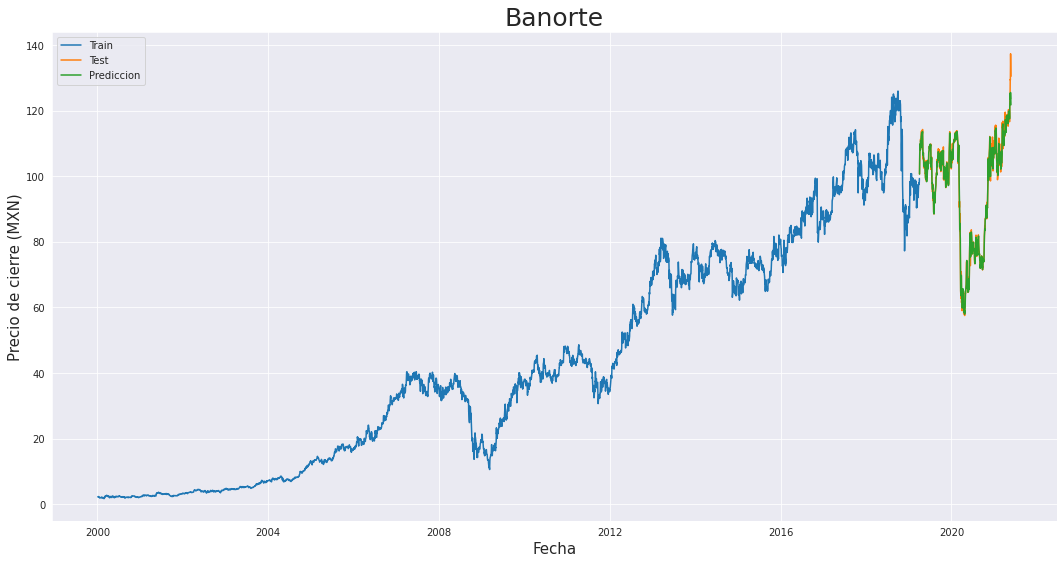

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Banorte', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

1.6581465455290876

In [ ]:
rf_final.score(X_test, y_test)

0.9939293605832783

In [ ]:
banorte_pred_1.tail()

Close       Lag 1       Lag 2    Diff 1
Date                                                    
2021-05-18  129.440002  125.900002  123.260002  3.540001
2021-05-19  129.289993  129.440002  125.900002 -0.150009
2021-05-20  136.000000  129.289993  129.440002  6.710007
2021-05-21  137.300003  136.000000  129.289993  1.300003
2021-05-24  130.449997  137.300003  136.000000 -6.850006

In [ ]:
train = banorte_pred_1.loc[:'2020-02-01', :]
test = banorte_pred_1.loc['2020-02-01':'2021-05-01', :]
val = banorte_pred_1.loc['2021-05-01':, :]

In [ ]:
train

Close       Lag 1       Lag 2    Diff 1
Date                                                    
2000-01-05    2.259999    2.190992    2.439419  0.069007
2000-01-06    2.294503    2.259999    2.190992  0.034504
2000-01-07    2.322106    2.294503    2.259999  0.027603
2000-01-10    2.360060    2.322106    2.294503  0.037954
2000-01-11    2.225495    2.360060    2.322106 -0.134565
...                ...         ...         ...       ...
2020-01-27  110.442879  111.168427  110.486702 -0.725548
2020-01-28  110.535400  110.442879  111.168427  0.092522
2020-01-29  112.677933  110.535400  110.442879  2.142532
2020-01-30  112.979843  112.677933  110.535400  0.301910
2020-01-31  113.096703  112.979843  112.677933  0.116859

[5034 rows x 4 columns]

In [ ]:
test

Close       Lag 1       Lag 2    Diff 1
Date                                                    
2020-02-04  113.315834  113.096703  112.979843  0.219131
2020-02-05  113.038269  113.315834  113.096703 -0.277565
2020-02-06  113.125923  113.038269  113.315834  0.087654
2020-02-07  111.012596  113.125923  113.038269 -2.113327
2020-02-10  111.148941  111.012596  113.125923  0.136345
...                ...         ...         ...       ...
2021-04-26  117.518120  118.774422  118.803642 -1.256302
2021-04-27  115.706703  117.518120  118.774422 -1.811417
2021-04-28  116.115738  115.706703  117.518120  0.409035
2021-04-29  118.082970  116.115738  115.706703  1.967232
2021-04-30  115.250000  118.082970  116.115738 -2.832970

[311 rows x 4 columns]

In [ ]:
val

Close       Lag 1       Lag 2    Diff 1
Date                                                    
2021-05-03  120.290001  115.250000  118.082970  5.040001
2021-05-04  119.809998  120.290001  115.250000 -0.480003
2021-05-05  118.080002  119.809998  120.290001 -1.729996
2021-05-06  119.160004  118.080002  119.809998  1.080002
2021-05-07  119.570000  119.160004  118.080002  0.409996
2021-05-10  120.099998  119.570000  119.160004  0.529999
2021-05-11  117.660004  120.099998  119.570000 -2.439995
2021-05-12  116.580002  117.660004  120.099998 -1.080002
2021-05-13  118.110001  116.580002  117.660004  1.529999
2021-05-14  123.260002  118.110001  116.580002  5.150002
2021-05-17  125.900002  123.260002  118.110001  2.639999
2021-05-18  129.440002  125.900002  123.260002  3.540001
2021-05-19  129.289993  129.440002  125.900002 -0.150009
2021-05-20  136.000000  129.289993  129.440002  6.710007
2021-05-21  137.300003  136.000000  129.289993  1.300003
2021-05-24  130.449997  137.300003  136.000000 -6.850006

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

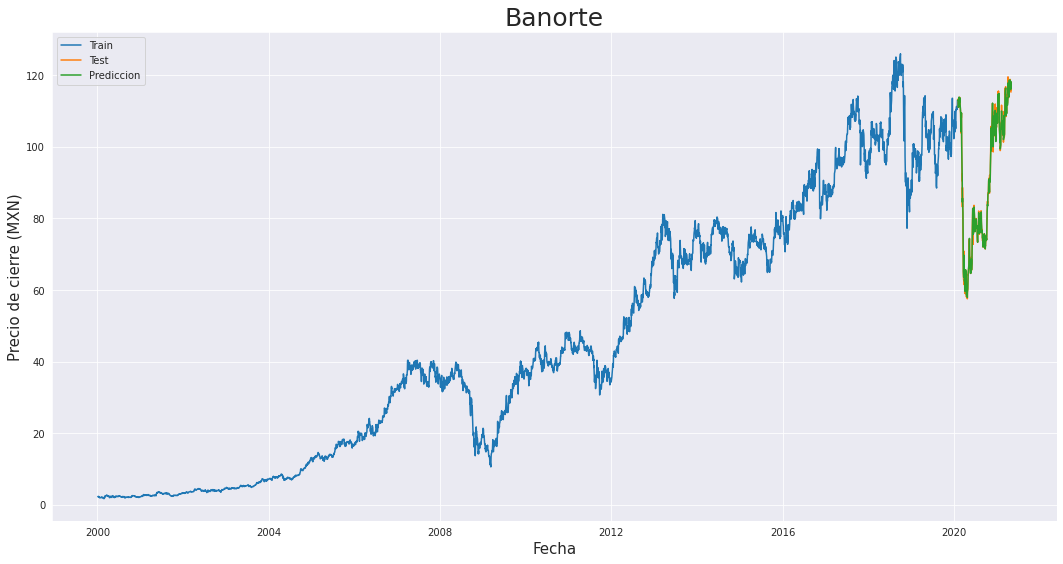

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Banorte', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

1.0351528107534194

In [ ]:
RF.score(X_test, y_test)

0.9969808289504888

In [ ]:
aux = banorte_pred_1.loc[:'2021-05-01', :]
aux

Close       Lag 1       Lag 2    Diff 1
Date                                                    
2000-01-05    2.259999    2.190992    2.439419  0.069007
2000-01-06    2.294503    2.259999    2.190992  0.034504
2000-01-07    2.322106    2.294503    2.259999  0.027603
2000-01-10    2.360060    2.322106    2.294503  0.037954
2000-01-11    2.225495    2.360060    2.322106 -0.134565
...                ...         ...         ...       ...
2021-04-26  117.518120  118.774422  118.803642 -1.256302
2021-04-27  115.706703  117.518120  118.774422 -1.811417
2021-04-28  116.115738  115.706703  117.518120  0.409035
2021-04-29  118.082970  116.115738  115.706703  1.967232
2021-04-30  115.250000  118.082970  116.115738 -2.832970

[5345 rows x 4 columns]

In [ ]:
fin = futuro(aux, 50, 1, len(y_val))
fin

Close       Lag 1       Lag 2      Diff 1
0   118.945388  115.250000  118.082970  116.115738
1   121.787616  118.945388  115.250000  118.082970
2   123.135142  121.787616  118.945388  115.250000
3   123.981472  123.135142  121.787616  118.945388
4   124.793450  123.981472  123.135142  121.787616
5   125.364755  124.793450  123.981472  123.135142
6   125.519725  125.364755  124.793450  123.981472
7   125.519725  125.519725  125.364755  124.793450
8   125.519725  125.519725  125.519725  125.364755
9   125.519725  125.519725  125.519725  125.519725
10  125.519725  125.519725  125.519725  125.519725
11  125.519725  125.519725  125.519725  125.519725
12  125.519725  125.519725  125.519725  125.519725
13  125.519725  125.519725  125.519725  125.519725
14  125.519725  125.519725  125.519725  125.519725
15  125.519725  125.519725  125.519725  125.519725

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close       Lag 1       Lag 2      Diff 1
Date                                                      
2021-05-03  118.945388  115.250000  118.082970  116.115738
2021-05-04  121.787616  118.945388  115.250000  118.082970
2021-05-05  123.135142  121.787616  118.945388  115.250000
2021-05-06  123.981472  123.135142  121.787616  118.945388
2021-05-07  124.793450  123.981472  123.135142  121.787616
2021-05-10  125.364755  124.793450  123.981472  123.135142
2021-05-11  125.519725  125.364755  124.793450  123.981472
2021-05-12  125.519725  125.519725  125.364755  124.793450
2021-05-13  125.519725  125.519725  125.519725  125.364755
2021-05-14  125.519725  125.519725  125.519725  125.519725
2021-05-17  125.519725  125.519725  125.519725  125.519725
2021-05-18  125.519725  125.519725  125.519725  125.519725
2021-05-19  125.519725  125.519725  125.519725  125.519725
2021-05-20  125.519725  125.519725  125.519725  125.519725
2021-05-21  125.519725  125.519725  125.519725  125.519725
2021-05-24  125.519725  125.519725  125.519725  125.519725

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close        Pred
Date                              
2021-05-03  120.290001  118.945388
2021-05-04  119.809998  121.787616
2021-05-05  118.080002  123.135142
2021-05-06  119.160004  123.981472
2021-05-07  119.570000  124.793450
2021-05-10  120.099998  125.364755
2021-05-11  117.660004  125.519725
2021-05-12  116.580002  125.519725
2021-05-13  118.110001  125.519725
2021-05-14  123.260002  125.519725
2021-05-17  125.900002  125.519725
2021-05-18  129.440002  125.519725
2021-05-19  129.289993  125.519725
2021-05-20  136.000000  125.519725
2021-05-21  137.300003  125.519725
2021-05-24  130.449997  125.519725

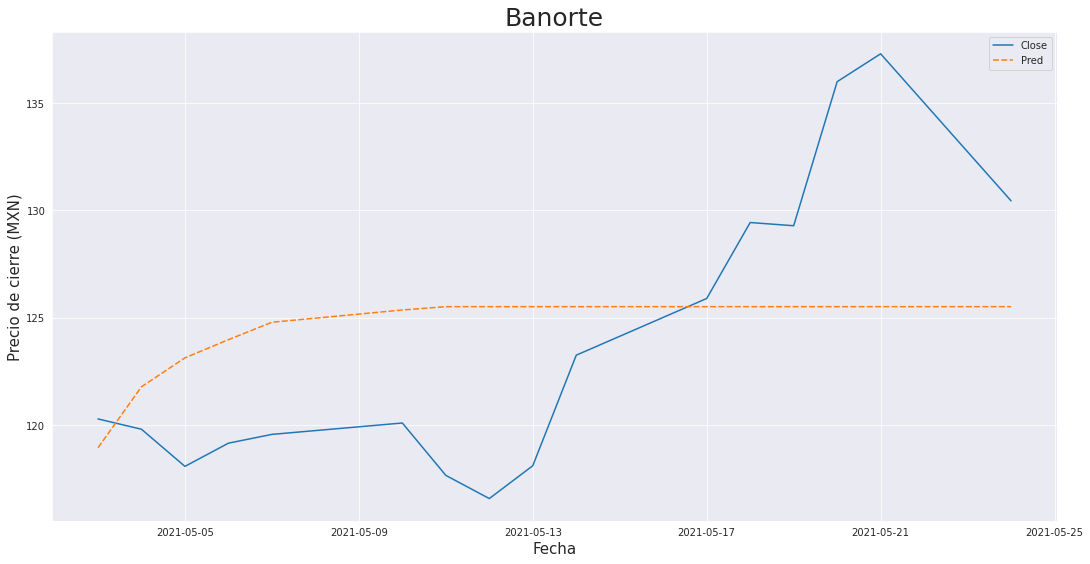

In [ ]:
#sns.lineplot(data = comp)
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('Banorte', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

38.36706841918626

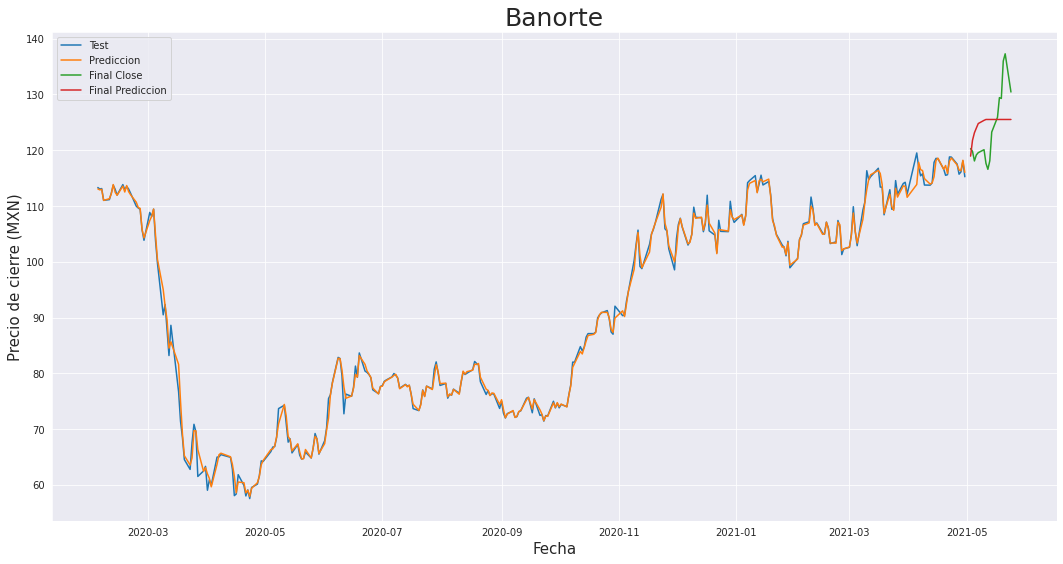

In [ ]:
plt.figure(figsize=(18,9))

# plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')
plt.plot(comp.index, comp['Close'], label='Final Close')
plt.plot(comp.index, comp['Pred'], label='Final Prediccion')

plt.title('Banorte', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

## Elektra

### Obteniendo informacion

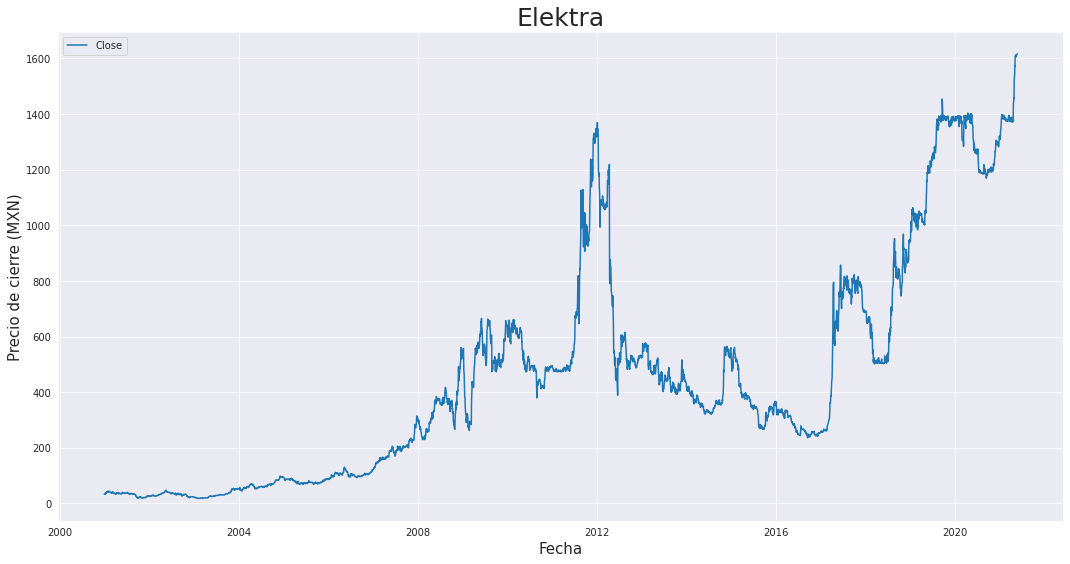

In [ ]:
elektra = info("ELEKTRA.MX","Close","Elektra")

In [ ]:
elektra.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5168 entries, 2000-12-25 to 2021-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5168 non-null   float64
dtypes: float64(1)
memory usage: 80.8 KB


### Crear predictores

In [ ]:
elektra_pred = predictores(a_movil, [1, 2, 3], [1, 5])

In [ ]:
elektra_pred.head()

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966

### Seleccion de train, test y validation

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(elektra_pred, 0.7, 0.2, 0.1)

In [ ]:
X_train

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2008-01-09  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...       ...       ...
2017-05-16  13.198915  12.904216  12.841705 -0.035723 -0.008932
2017-05-17  13.163193  13.198915  12.904216 -0.178604 -0.205397
2017-05-18  12.984589  13.163193  13.198915 -0.321489 -0.178606
2017-05-19  12.663099  12.984589  13.163193  0.535816  0.294700
2017-05-22  13.198915  12.663099  12.984589 -0.044651 -0.044651

[2347 rows x 5 columns]

In [ ]:
X_test

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2017-05-23  13.154264  13.198915  12.663099  0.053580  0.044652
2017-05-24  13.207845  13.154264  13.198915  0.116094  0.339350
2017-05-25  13.323938  13.207845  13.154264 -0.062511  0.598328
2017-05-26  13.261427  13.323938  13.207845  0.196466  0.258978
2017-05-29  13.457893  13.261427  13.323938 -0.080374  0.223255
...               ...        ...        ...       ...       ...
2020-01-15  14.291131  14.425322  14.473247 -0.057508 -0.134189
2020-01-16  14.233623  14.291131  14.425322  0.440907  0.254000
2020-01-17  14.674529  14.233623  14.291131  0.182114  0.383396
2020-01-20  14.856643  14.674529  14.233623  0.009585  0.440907
2020-01-21  14.866228  14.856643  14.674529  0.076679  0.651776

[671 rows x 5 columns]

In [ ]:
X_val

Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                           
2020-01-22  14.942907  14.866228  14.856643 -0.076679  0.632606
2020-01-23  14.866228  14.942907  14.866228  0.182114  0.373813
2020-01-24  15.048342  14.866228  14.942907 -0.019170  0.172529
2020-01-27  15.029172  15.048342  14.866228 -0.354643 -0.191699
2020-01-28  14.674529  15.029172  15.048342  0.402567  0.134189
...               ...        ...        ...       ...       ...
2021-05-19  14.900000  14.790000  14.670000 -0.099999  0.060000
2021-05-20  14.800000  14.900000  14.790000  0.270000  0.309999
2021-05-21  15.070000  14.800000  14.900000 -0.099999  0.300000
2021-05-24  14.970000  15.070000  14.800000  0.070000  0.250000
2021-05-25  15.040000  14.970000  15.070000 -0.140000  0.000000

[336 rows x 5 columns]

In [ ]:
y_train

Date
2008-01-09    12.260990
2008-01-10    12.591238
2008-01-11    12.321725
2008-01-14    12.147110
2008-01-15    11.801676
                ...    
2017-05-16    13.163193
2017-05-17    12.984589
2017-05-18    12.663099
2017-05-19    13.198915
2017-05-22    13.154264
Name: Close, Length: 2347, dtype: float64

In [ ]:
y_test

Date
2017-05-23    13.207845
2017-05-24    13.323938
2017-05-25    13.261427
2017-05-26    13.457893
2017-05-29    13.377520
                ...    
2020-01-15    14.233623
2020-01-16    14.674529
2020-01-17    14.856643
2020-01-20    14.866228
2020-01-21    14.942907
Name: Close, Length: 671, dtype: float64

In [ ]:
y_val

Date
2020-01-22    14.866228
2020-01-23    15.048342
2020-01-24    15.029172
2020-01-27    14.674529
2020-01-28    15.077096
                ...    
2021-05-19    14.800000
2021-05-20    15.070000
2021-05-21    14.970000
2021-05-24    15.040000
2021-05-25    14.900000
Name: Close, Length: 336, dtype: float64

### Aplicacion del Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf.predict(X_test)

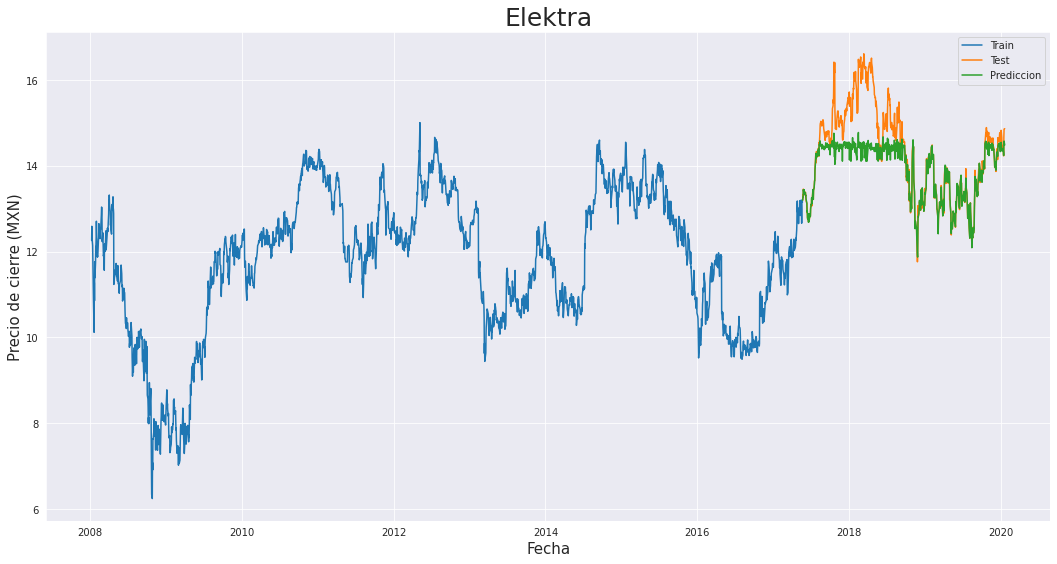

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Elektra', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

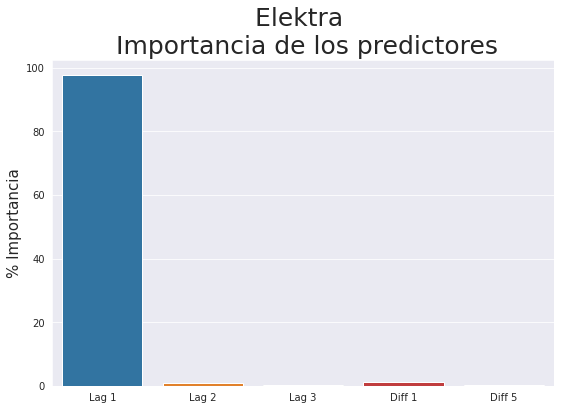

In [ ]:
plt.figure(figsize=(9,6))

sns.barplot(x = X_train.columns, y = rf.feature_importances_*100)
plt.title('Elektra \n Importancia de los predictores', fontsize = 25)
plt.ylabel('% Importancia', fontsize = 15)
plt.show()

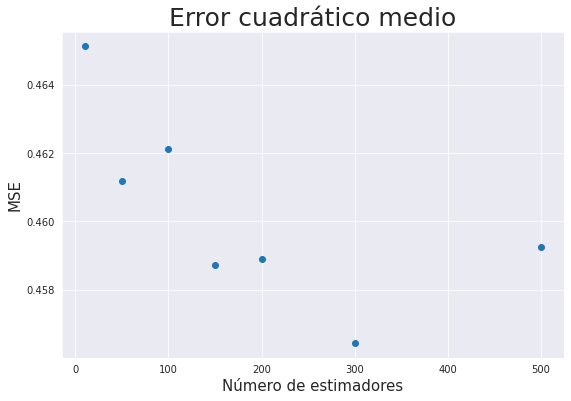

'El número mínimo de estimadores es 300'

In [ ]:
optimizer(X_train, y_train, X_test, y_test, [10, 50, 100, 150, 200, 300, 500], 1)

In [ ]:
elektra_pred_1 = predictores(a_movil,[1,2],[1])
X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid(elektra_pred_1, 0.9, 0.1, 0)

In [ ]:
rf_final = RandomForestRegressor(n_estimators = 300, random_state = 1)

rf_final.fit(X_train, y_train)
preds = pd.DataFrame(y_test)
preds['Prediccion'] = rf_final.predict(X_test)

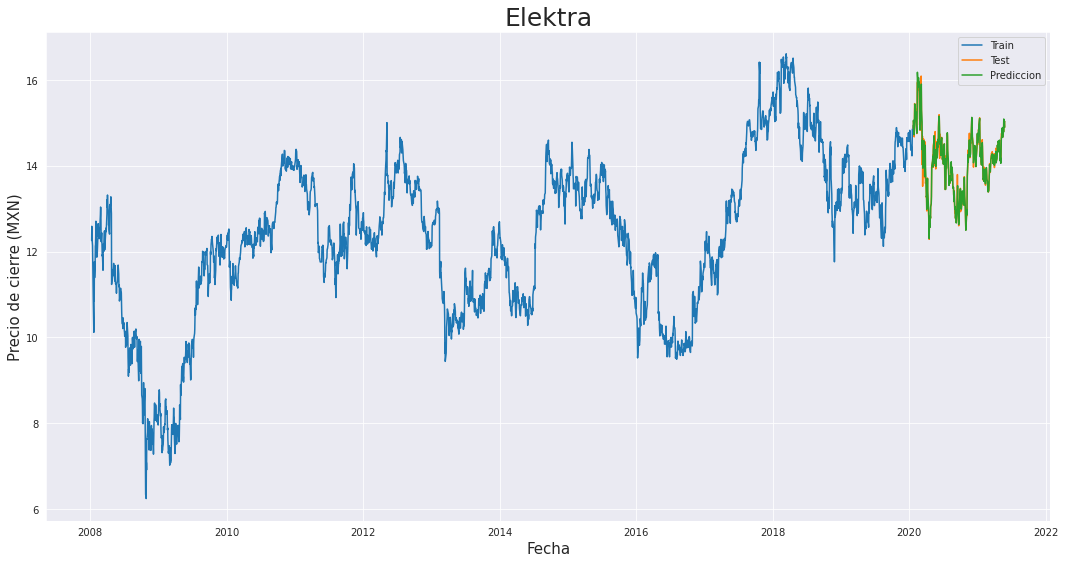

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Elektra', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.011160757878456665

In [ ]:
rf_final.score(X_test, y_test)

0.9791206531534736

In [ ]:
elektra_pred_1.tail()

Close  Lag 1  Lag 2  Lag 3    Diff 1    Diff 5
Date                                                      
2021-05-19  14.80  14.90  14.79  14.67 -0.099999  0.060000
2021-05-20  15.07  14.80  14.90  14.79  0.270000  0.309999
2021-05-21  14.97  15.07  14.80  14.90 -0.099999  0.300000
2021-05-24  15.04  14.97  15.07  14.80  0.070000  0.250000
2021-05-25  14.90  15.04  14.97  15.07 -0.140000  0.000000

In [ ]:
elektra_pred_1.tail()

Close  Lag 1  Lag 2  Lag 3    Diff 1    Diff 5
Date                                                      
2021-05-19  14.80  14.90  14.79  14.67 -0.099999  0.060000
2021-05-20  15.07  14.80  14.90  14.79  0.270000  0.309999
2021-05-21  14.97  15.07  14.80  14.90 -0.099999  0.300000
2021-05-24  15.04  14.97  15.07  14.80  0.070000  0.250000
2021-05-25  14.90  15.04  14.97  15.07 -0.140000  0.000000

In [ ]:
train = elektra_pred_1.loc[:'2020-02-01', :]
test = elektra_pred_1.loc['2020-02-01':'2021-05-01', :]
val = elektra_pred_1.loc['2021-05-01':, :]

In [ ]:
train

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...        ...       ...       ...
2020-01-27  14.674529  15.029172  15.048342  14.866228 -0.354643 -0.191699
2020-01-28  15.077096  14.674529  15.029172  15.048342  0.402567  0.134189
2020-01-29  15.450910  15.077096  14.674529  15.029172  0.373814  0.584682
2020-01-30  15.393399  15.450910  15.077096  14.674529 -0.057510  0.345057
2020-01-31  15.043549  15.393399  15.450910  15.077096 -0.349851  0.014377

[3026 rows x 6 columns]

In [ ]:
test

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2020-02-04  15.326303  15.043549  15.393399  15.450910  0.282755  0.651774
2020-02-05  15.230456  15.326303  15.043549  15.393399 -0.095847  0.153360
2020-02-06  15.029172  15.230456  15.326303  15.043549 -0.201284 -0.421738
2020-02-07  14.990833  15.029172  15.230456  15.326303 -0.038339 -0.402566
2020-02-10  14.751209  14.990833  15.029172  15.230456 -0.239624 -0.292339
...               ...        ...        ...        ...       ...       ...
2021-04-26  14.570000  14.500000  14.560000  14.500000  0.070000  0.230000
2021-04-27  14.590000  14.570000  14.500000  14.560000  0.020000  0.020000
2021-04-28  14.300000  14.590000  14.570000  14.500000 -0.290000 -0.200000
2021-04-29  14.310000  14.300000  14.590000  14.570000  0.010000 -0.250000
2021-04-30  14.150000  14.310000  14.300000  14.590000 -0.160001 -0.350000

[311 rows x 6 columns]

In [ ]:
val

Close  Lag 1  Lag 2  Lag 3    Diff 1    Diff 5
Date                                                      
2021-05-03  14.17  14.15  14.31  14.30  0.020000 -0.400000
2021-05-04  14.07  14.17  14.15  14.31 -0.100000 -0.520000
2021-05-05  14.16  14.07  14.17  14.15  0.090000 -0.140000
2021-05-06  14.45  14.16  14.07  14.17  0.290000  0.139999
2021-05-07  14.75  14.45  14.16  14.07  0.300000  0.600000
2021-05-10  14.74  14.75  14.45  14.16 -0.010000  0.570000
2021-05-11  14.87  14.74  14.75  14.45  0.130000  0.800000
2021-05-12  14.74  14.87  14.74  14.75 -0.130000  0.580000
2021-05-13  14.76  14.74  14.87  14.74  0.020000  0.310000
2021-05-14  14.67  14.76  14.74  14.87 -0.090000 -0.080000
2021-05-17  14.79  14.67  14.76  14.74  0.120000  0.050000
2021-05-18  14.90  14.79  14.67  14.76  0.110000  0.030000
2021-05-19  14.80  14.90  14.79  14.67 -0.099999  0.060000
2021-05-20  15.07  14.80  14.90  14.79  0.270000  0.309999
2021-05-21  14.97  15.07  14.80  14.90 -0.099999  0.300000
2021-05-24  15.04  14.97  15.07  14.80  0.070000  0.250000
2021-05-25  14.90  15.04  14.97  15.07 -0.140000  0.000000

In [ ]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

In [ ]:
RF = RandomForestRegressor(n_estimators=50, random_state=1)
RF.fit(X_train, y_train)

preds = pd.DataFrame(y_test)
preds['Prediccion'] = RF.predict(X_test)

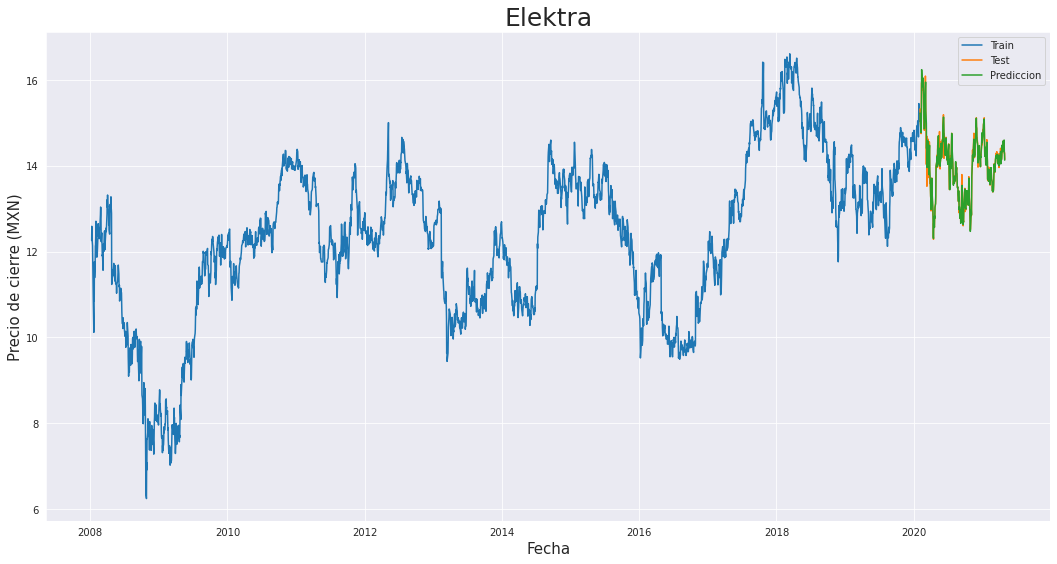

In [ ]:
plt.figure(figsize=(18,9))

plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')

plt.title('Elektra', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(preds['Close'], preds['Prediccion'])

0.011921701039362237

In [ ]:
RF.score(X_test, y_test)

0.977240066084039

In [ ]:
aux = a_movil_pred_1.loc[:'2021-05-01', :]
aux

Close      Lag 1      Lag 2      Lag 3    Diff 1    Diff 5
Date                                                                      
2008-01-09  12.260990  12.211642  11.999069  12.139519  0.049348 -0.037959
2008-01-10  12.591238  12.260990  12.211642  11.999069  0.330248  0.235352
2008-01-11  12.321725  12.591238  12.260990  12.211642 -0.269513  0.182206
2008-01-14  12.147110  12.321725  12.591238  12.260990 -0.174615  0.148041
2008-01-15  11.801676  12.147110  12.321725  12.591238 -0.345434 -0.409966
...               ...        ...        ...        ...       ...       ...
2021-04-26  14.570000  14.500000  14.560000  14.500000  0.070000  0.230000
2021-04-27  14.590000  14.570000  14.500000  14.560000  0.020000  0.020000
2021-04-28  14.300000  14.590000  14.570000  14.500000 -0.290000 -0.200000
2021-04-29  14.310000  14.300000  14.590000  14.570000  0.010000 -0.250000
2021-04-30  14.150000  14.310000  14.300000  14.590000 -0.160001 -0.350000

[3337 rows x 6 columns]

In [ ]:
fin = futuro(aux, 50, 1, len(y_val))
fin

Close      Lag 1      Lag 2      Lag 3     Diff 1     Diff 5
0   14.699507  14.150000  14.310000  14.300000  14.590000  -0.160001
1   15.074059  14.699507  14.150000  14.310000  14.300000  14.590000
2   15.722027  15.074059  14.699507  14.150000  14.310000  14.300000
3   16.207680  15.722027  15.074059  14.699507  14.150000  14.310000
4   16.392474  16.207680  15.722027  15.074059  14.699507  14.150000
5   16.466249  16.392474  16.207680  15.722027  15.074059  14.699507
6   16.533079  16.466249  16.392474  16.207680  15.722027  15.074059
7   16.556485  16.533079  16.466249  16.392474  16.207680  15.722027
8   16.542161  16.556485  16.533079  16.466249  16.392474  16.207680
9   16.525448  16.542161  16.556485  16.533079  16.466249  16.392474
10  16.525448  16.525448  16.542161  16.556485  16.533079  16.466249
11  16.525448  16.525448  16.525448  16.542161  16.556485  16.533079
12  16.525448  16.525448  16.525448  16.525448  16.542161  16.556485
13  16.525448  16.525448  16.525448  16.525448  16.525448  16.542161
14  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
15  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
16  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448

In [ ]:
fin = fin.set_index(y_val.index)
fin

Close      Lag 1      Lag 2      Lag 3     Diff 1     Diff 5
Date                                                                        
2021-05-03  14.699507  14.150000  14.310000  14.300000  14.590000  -0.160001
2021-05-04  15.074059  14.699507  14.150000  14.310000  14.300000  14.590000
2021-05-05  15.722027  15.074059  14.699507  14.150000  14.310000  14.300000
2021-05-06  16.207680  15.722027  15.074059  14.699507  14.150000  14.310000
2021-05-07  16.392474  16.207680  15.722027  15.074059  14.699507  14.150000
2021-05-10  16.466249  16.392474  16.207680  15.722027  15.074059  14.699507
2021-05-11  16.533079  16.466249  16.392474  16.207680  15.722027  15.074059
2021-05-12  16.556485  16.533079  16.466249  16.392474  16.207680  15.722027
2021-05-13  16.542161  16.556485  16.533079  16.466249  16.392474  16.207680
2021-05-14  16.525448  16.542161  16.556485  16.533079  16.466249  16.392474
2021-05-17  16.525448  16.525448  16.542161  16.556485  16.533079  16.466249
2021-05-18  16.525448  16.525448  16.525448  16.542161  16.556485  16.533079
2021-05-19  16.525448  16.525448  16.525448  16.525448  16.542161  16.556485
2021-05-20  16.525448  16.525448  16.525448  16.525448  16.525448  16.542161
2021-05-21  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
2021-05-24  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448
2021-05-25  16.525448  16.525448  16.525448  16.525448  16.525448  16.525448

In [ ]:
comp = pd.DataFrame(y_val)
comp['Pred'] = fin.Close
comp

Close       Pred
Date                        
2021-05-03  14.17  14.699507
2021-05-04  14.07  15.074059
2021-05-05  14.16  15.722027
2021-05-06  14.45  16.207680
2021-05-07  14.75  16.392474
2021-05-10  14.74  16.466249
2021-05-11  14.87  16.533079
2021-05-12  14.74  16.556485
2021-05-13  14.76  16.542161
2021-05-14  14.67  16.525448
2021-05-17  14.79  16.525448
2021-05-18  14.90  16.525448
2021-05-19  14.80  16.525448
2021-05-20  15.07  16.525448
2021-05-21  14.97  16.525448
2021-05-24  15.04  16.525448
2021-05-25  14.90  16.525448

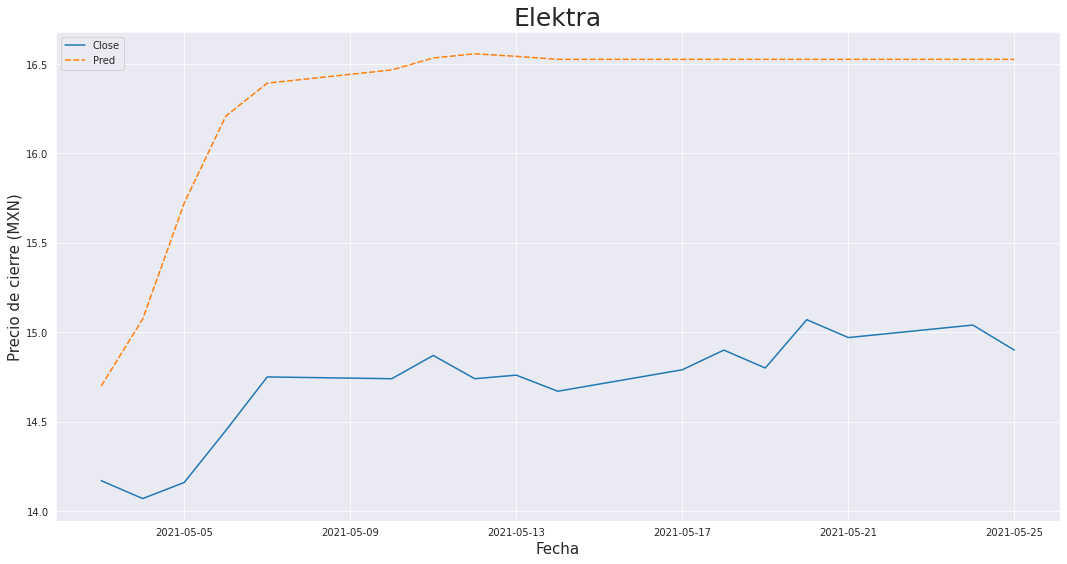

In [ ]:
#sns.lineplot(data = comp)
plt.figure(figsize=(18,9))

sns.lineplot(data = comp)

plt.title('Elektra', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(comp['Close'], comp['Pred'])

2.5410113094559934

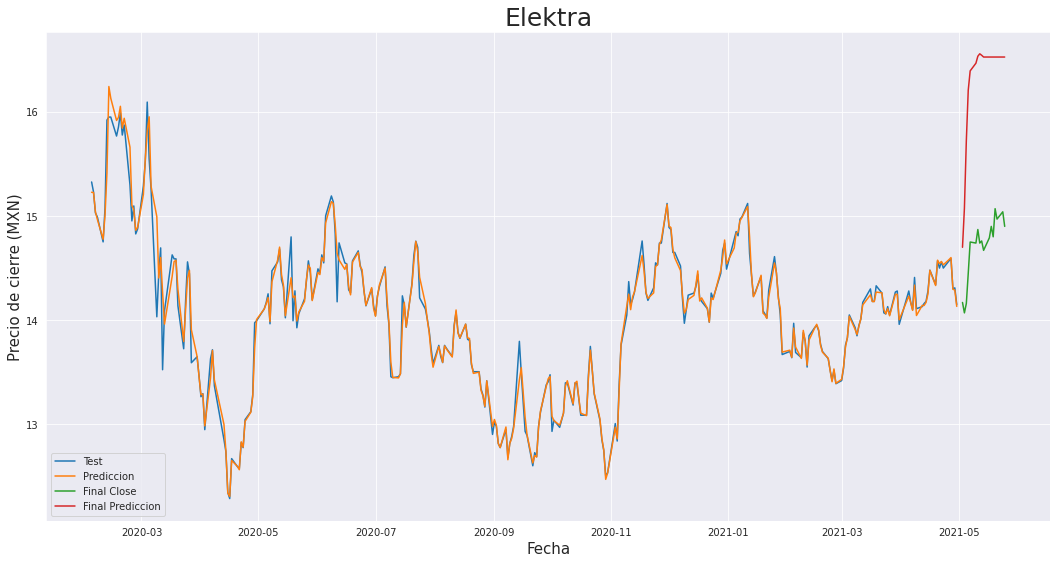

In [ ]:
plt.figure(figsize=(18,9))

# plt.plot(X_train.index, y_train, label='Train')
plt.plot(preds.index, preds['Close'], label='Test')
plt.plot(preds.index, preds['Prediccion'], label='Prediccion')
plt.plot(comp.index, comp['Close'], label='Final Close')
plt.plot(comp.index, comp['Pred'], label='Final Prediccion')

plt.title('Elektra', fontsize = 25)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Precio de cierre (MXN)', fontsize = 15)
plt.legend()
plt.show()